### Vibration of a thin plate

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

import scipy
import numpy as np
import pandas as pd

from IPython.display import clear_output
import time

### 1. Initialization

In [70]:
# Whole plane body size 0 < x < a and 0 < y < b
a = 1
b = 1

# Grid will be (Nx-1) * (Ny-1) elements
Nx = 51
Ny = 51
number_of_elements = (Nx-1)*(Ny-1)

x_grid = np.outer(np.linspace(0, a, Nx), np.ones(Nx))
y_grid = np.outer(np.linspace(0, b, Ny), np.ones(Ny)).T

lx = x_grid[1][0]
ly = y_grid[0][1]

print(f"Space delta: lx = {lx}, ly = {ly}")

# Whether use sparse arithmetic or not
sparse_calculation = number_of_elements > 300

# Boundary conditions:
# "CCCC": Displacement W = 0, Bending angle O = 0, Twisting angle O = 0
# "SSSS": Displacement W = 0, Bending moment M = 0, Twisting angle O = 0
# "FFFF": Bending moment M = 0, Twisting moment M = 0, Force Q = 0

plate_info = {
    "shape"      : "rectangular plate + beam",
                 # "rectangular", "rectangular-cutout", "rectangular-support-points",
                 # "rectangular-beam-like", "rectangular-strip-beam-like", "rectangular-soap-film-cutout"
                 # "rectangular plate + beam", "just beam"
    "boundaries" : {
        "bottom" : "SSSS",
        "left"   : "FFFF",
        "top"    : "SSSS",
        "right"  : "FFFF",
    },
    "cutout range"              : [0.4, 0.4],
                                # x-percentage cutout size and y-percentage cutout size
    					        # Inner cutout boundaries by default: "FFFF"
    "support points"            : [[a/4,b/4], [3*a/4,b/4], [a/4,3*b/4], [3*a/4,3*b/4]],
    "central beam-element size" : 100,
    "beam length"               : 1.4
}

# Physical parameters
if plate_info["shape"] == "rectangular plate + beam":
    v = 0.3
    E = 2e10
    h = 0.006
    pho = 2700

    Bb = 0.004
    Hb = 0.004
    K = Hb**4 * 0.1408333
    Ip = Bb*Hb*(Bb**2 + Hb**2)/12
    beta = 1/3
    D = E * h**3 / (12 * (1-v**2))
    F = 1
else:
    v = 0.3
    E = 2e10
    h = 0.006
    pho = 2700
    D = E * h**3 / (12 * (1-v**2))

Space delta: lx = 0.02, ly = 0.02


### 2. MMS algorithm program core

#### 2.1. Krylov functions

In [29]:
def K1(gamma,arg):
    return 0.5*(np.cosh(gamma*arg) + np.cos(gamma*arg))

In [30]:
def K2(gamma,arg):
    return 0.5*(np.sinh(gamma*arg) + np.sin(gamma*arg)) / gamma

In [32]:
def K3(gamma,arg):
    return 0.5*(np.cosh(gamma*arg) - np.cos(gamma*arg)) / gamma**2

In [39]:
def K4(gamma,arg):
    return 0.5*(np.sinh(gamma*arg) - np.sin(gamma*arg)) / gamma**3

#### 2.2. Transfer matrix equestions

In [34]:
def rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements):
    A = np.zeros((number_of_elements*30,number_of_elements*30))
    B = np.zeros(number_of_elements*30)

    for element in range(number_of_elements):
        # Field equations

        # Displacement w(x)
        A[0 + element*30][12 + element*30] = 1
        A[0 + element*30][0 + element*30] = -K1(gamma,lx)
        A[0 + element*30][1 + element*30] = -K2(gamma,lx)
        A[0 + element*30][3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30][26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30][28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30][13 + element*30] = 1
        A[1 + element*30][0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30][1 + element*30] = -K1(gamma,lx)
        A[1 + element*30][3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30][26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30][28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30][14 + element*30] = 1
        A[2 + element*30][2 + element*30] = -1
        A[2 + element*30][4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30][29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30][15 + element*30] = 1
        A[3 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30][3 + element*30] = -K1(gamma,lx)
        A[3 + element*30][5 + element*30] = -K2(gamma,lx)
        A[3 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30][28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30][16 + element*30] = 1
        A[4 + element*30][4 + element*30] = -1
        A[4 + element*30][29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30][17 + element*30] = 1
        A[5 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30][3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30][5 + element*30] = -K1(gamma,lx)
        A[5 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30][28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30][18 + element*30] = 1
        A[6 + element*30][6 + element*30] = -K1(gamma,ly)
        A[6 + element*30][7 + element*30] = -K2(gamma,ly)
        A[6 + element*30][9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30][29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30][19 + element*30] = 1
        A[7 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30][7 + element*30] = -K1(gamma,ly)
        A[7 + element*30][9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30][29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30][20 + element*30] = 1
        A[8 + element*30][8 + element*30] = -1
        A[8 + element*30][10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30][28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30][21 + element*30] = 1
        A[9 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30][9 + element*30] = -K1(gamma,ly)
        A[9 + element*30][11 + element*30] = -K2(gamma,ly)
        A[9 + element*30][25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30][29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30][22 + element*30] = 1
        A[10 + element*30][10 + element*30] = -1
        A[10 + element*30][28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30][23 + element*30] = 1
        A[11 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30][9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30][11 + element*30] = -K1(gamma,ly)
        A[11 + element*30][25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30][29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30][2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30][3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30][3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30][4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30][5 + element*30] = 1 # Force Q = 0
        else:
            A[12 + element*30][15 + (element-1)*30] = 1
            A[12 + element*30][3 + element*30] = -1
            A[13 + element*30][16 + (element-1)*30] = 1
            A[13 + element*30][4 + element*30] = -1
            A[14 + element*30][17 + (element-1)*30] = 1
            A[14 + element*30][5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30][8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30][9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30][9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30][10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30][11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30][21 + (element-(Nx-1))*30] = 1
            A[15 + element*30][9 + element*30] = -1
            A[16 + element*30][22 + (element-(Nx-1))*30] = 1
            A[16 + element*30][10 + element*30] = -1
            A[17 + element*30][23 + (element-(Nx-1))*30] = 1
            A[17 + element*30][11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30][14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30][15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30][15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30][16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30][17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30][12 + element*30] = 1
            A[18 + element*30][0 + (element+1)*30] = -1
            A[19 + element*30][13 + element*30] = 1
            A[19 + element*30][1 + (element+1)*30] = -1
            A[20 + element*30][14 + element*30] = 1
            A[20 + element*30][2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30][20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"]== "SSSS":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30][21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30][21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30][22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30][23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30][18 + element*30] = 1
            A[21 + element*30][6 + (element+(Nx-1))*30] = -1
            A[22 + element*30][19 + element*30] = 1
            A[22 + element*30][7 + (element+(Nx-1))*30] = -1
            A[23 + element*30][20 + element*30] = 1
            A[23 + element*30][8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30][25 + element*30] = 1
        A[24 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30][3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30][5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30][28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30][26 + element*30] = 1
        A[25 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30][9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30][11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30][25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30][29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30][24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30][0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30][1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30][3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30][28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30][24 + element*30] = 1
        A[27 + element*30][6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30][7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30][9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30][29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30][0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30][3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30][28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30][8 + element*30] = -1
        A[28 + element*30][10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30][2 + element*30] = 1
        A[29 + element*30][4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30][29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30][7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30][9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    return A, B

In [31]:
def rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements):
    A = scipy.sparse.lil_matrix((number_of_elements*30,number_of_elements*30))
    B = scipy.sparse.lil_matrix((number_of_elements*30,1))

    for element in range(number_of_elements):
        # Field equations

        # Displacement w(x)
        A[0 + element*30,12 + element*30] = 1
        A[0 + element*30,0 + element*30] = -K1(gamma,lx)
        A[0 + element*30,1 + element*30] = -K2(gamma,lx)
        A[0 + element*30,3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30,26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30,28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30,13 + element*30] = 1
        A[1 + element*30,0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30,1 + element*30] = -K1(gamma,lx)
        A[1 + element*30,3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30,26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30,28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30,14 + element*30] = 1
        A[2 + element*30,2 + element*30] = -1
        A[2 + element*30,4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30,29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30,15 + element*30] = 1
        A[3 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30,3 + element*30] = -K1(gamma,lx)
        A[3 + element*30,5 + element*30] = -K2(gamma,lx)
        A[3 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30,28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30,16 + element*30] = 1
        A[4 + element*30,4 + element*30] = -1
        A[4 + element*30,29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30,17 + element*30] = 1
        A[5 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30,3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30,5 + element*30] = -K1(gamma,lx)
        A[5 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30,28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30,18 + element*30] = 1
        A[6 + element*30,6 + element*30] = -K1(gamma,ly)
        A[6 + element*30,7 + element*30] = -K2(gamma,ly)
        A[6 + element*30,9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30,29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30,19 + element*30] = 1
        A[7 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30,7 + element*30] = -K1(gamma,ly)
        A[7 + element*30,9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30,29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30,20 + element*30] = 1
        A[8 + element*30,8 + element*30] = -1
        A[8 + element*30,10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30,28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30,21 + element*30] = 1
        A[9 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30,9 + element*30] = -K1(gamma,ly)
        A[9 + element*30,11 + element*30] = -K2(gamma,ly)
        A[9 + element*30,25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30,29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30,22 + element*30] = 1
        A[10 + element*30,10 + element*30] = -1
        A[10 + element*30,28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30,23 + element*30] = 1
        A[11 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30,9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30,11 + element*30] = -K1(gamma,ly)
        A[11 + element*30,25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30,29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30,2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30,3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30,3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30,4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30,5 + element*30] = 1 # Force Q = 0
        else:
            A[12 + element*30,15 + (element-1)*30] = 1
            A[12 + element*30,3 + element*30] = -1
            A[13 + element*30,16 + (element-1)*30] = 1
            A[13 + element*30,4 + element*30] = -1
            A[14 + element*30,17 + (element-1)*30] = 1
            A[14 + element*30,5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30,8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"]== "SSSS":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30,9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30,9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30,10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30,11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30,21 + (element-(Nx-1))*30] = 1
            A[15 + element*30,9 + element*30] = -1
            A[16 + element*30,22 + (element-(Nx-1))*30] = 1
            A[16 + element*30,10 + element*30] = -1
            A[17 + element*30,23 + (element-(Nx-1))*30] = 1
            A[17 + element*30,11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30,14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30,15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30,15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30,16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30,17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30,12 + element*30] = 1
            A[18 + element*30,0 + (element+1)*30] = -1
            A[19 + element*30,13 + element*30] = 1
            A[19 + element*30,1 + (element+1)*30] = -1
            A[20 + element*30,14 + element*30] = 1
            A[20 + element*30,2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30,20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"] == "SSSS":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30,21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30,21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30,22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30,23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30,18 + element*30] = 1
            A[21 + element*30,6 + (element+(Nx-1))*30] = -1
            A[22 + element*30,19 + element*30] = 1
            A[22 + element*30,7 + (element+(Nx-1))*30] = -1
            A[23 + element*30,20 + element*30] = 1
            A[23 + element*30,8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30,25 + element*30] = 1
        A[24 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30,3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30,5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30,28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30,26 + element*30] = 1
        A[25 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30,9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30,11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30,25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30,29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30,24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30,0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30,1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30,3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30,28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30,24 + element*30] = 1
        A[27 + element*30,6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30,7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30,9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30,29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30,0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30,3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30,28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30,8 + element*30] = -1
        A[28 + element*30,10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30,2 + element*30] = 1
        A[29 + element*30,4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30,29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30,7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30,9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    return A, B

In [33]:
def cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements):
    def remove_rows_by_index(sparse_matrix, start_index, cutout_size):
        # Create slices for rows before and after the row to be removed
        rows_before = sparse_matrix[:start_index, :]
        rows_after = sparse_matrix[start_index + cutout_size:, :]

        # Concatenate the slices to form the new sparse matrix without the row
        return np.vstack([rows_before, rows_after])

    def remove_columns_by_index(sparse_matrix, start_index, cutout_size):
        # Create slices for columns before and after the column to be removed
        cols_before = sparse_matrix[:, :start_index]
        cols_after = sparse_matrix[:, start_index + cutout_size:]

        # Concatenate the slices to form the new sparse matrix without the column
        return np.hstack([cols_before, cols_after])

    A = np.zeros((number_of_elements*30,number_of_elements*30))
    B = np.zeros(number_of_elements*30)

    cutout_range_x, cutout_range_y = plate_info["cutout range"]

    cutout_size_x = int(cutout_range_x * (Nx - 1))
    cutout_size_y = int(cutout_range_y * (Ny - 1))

    edge_size_x = int(((Nx - 1) - cutout_size_x) / 2)
    edge_size_y = int(((Ny - 1) - cutout_size_y) / 2)

    cutout_elements = []
    for j in range((Ny-1)*edge_size_y + edge_size_x,(Ny-1)*edge_size_y + cutout_size_y*(Ny-1), (Ny-1)):
        for i in range(cutout_size_x):
            cutout_elements.append(j + i)

    element = 0
    while element < number_of_elements:
        # Field equations

        # Displacement w(x)
        A[0 + element*30][12 + element*30] = 1
        A[0 + element*30][0 + element*30] = -K1(gamma,lx)
        A[0 + element*30][1 + element*30] = -K2(gamma,lx)
        A[0 + element*30][3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30][26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30][28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30][13 + element*30] = 1
        A[1 + element*30][0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30][1 + element*30] = -K1(gamma,lx)
        A[1 + element*30][3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30][26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30][28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30][14 + element*30] = 1
        A[2 + element*30][2 + element*30] = -1
        A[2 + element*30][4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30][29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30][15 + element*30] = 1
        A[3 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30][3 + element*30] = -K1(gamma,lx)
        A[3 + element*30][5 + element*30] = -K2(gamma,lx)
        A[3 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30][28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30][16 + element*30] = 1
        A[4 + element*30][4 + element*30] = -1
        A[4 + element*30][29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30][17 + element*30] = 1
        A[5 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30][3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30][5 + element*30] = -K1(gamma,lx)
        A[5 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30][28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30][18 + element*30] = 1
        A[6 + element*30][6 + element*30] = -K1(gamma,ly)
        A[6 + element*30][7 + element*30] = -K2(gamma,ly)
        A[6 + element*30][9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30][29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30][19 + element*30] = 1
        A[7 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30][7 + element*30] = -K1(gamma,ly)
        A[7 + element*30][9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30][29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30][20 + element*30] = 1
        A[8 + element*30][8 + element*30] = -1
        A[8 + element*30][10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30][28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30][21 + element*30] = 1
        A[9 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30][9 + element*30] = -K1(gamma,ly)
        A[9 + element*30][11 + element*30] = -K2(gamma,ly)
        A[9 + element*30][25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30][29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30][22 + element*30] = 1
        A[10 + element*30][10 + element*30] = -1
        A[10 + element*30][28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30][23 + element*30] = 1
        A[11 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30][9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30][11 + element*30] = -K1(gamma,ly)
        A[11 + element*30][25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30][29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30][2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30][3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30][3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30][4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30][5 + element*30] = 1 # Force Q = 0
        elif element - 1 in cutout_elements:       # Inner boundaries: "FFFF" by default
            A[12 + element*30][3 + element*30] = 1 # Bending moment M = 0
            A[13 + element*30][4 + element*30] = 1 # Twisting moment M = 0
            A[14 + element*30][5 + element*30] = 1 # Force Q = 0
        else:
            A[12 + element*30][15 + (element-1)*30] = 1
            A[12 + element*30][3 + element*30] = -1
            A[13 + element*30][16 + (element-1)*30] = 1
            A[13 + element*30][4 + element*30] = -1
            A[14 + element*30][17 + (element-1)*30] = 1
            A[14 + element*30][5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30][8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30][9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30][9 + element*30] = 1  # Bending moment M = 0
                A[16 + element*30][10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30][11 + element*30] = 1 # Force Q = 0
        elif element - (Nx-1) in cutout_elements:   # Inner boundaries: "FFFF" by default
            A[15 + element*30][9 + element*30] = 1  # Bending moment M = 0
            A[16 + element*30][10 + element*30] = 1 # Twisting moment M = 0
            A[17 + element*30][11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30][21 + (element-(Nx-1))*30] = 1
            A[15 + element*30][9 + element*30] = -1
            A[16 + element*30][22 + (element-(Nx-1))*30] = 1
            A[16 + element*30][10 + element*30] = -1
            A[17 + element*30][23 + (element-(Nx-1))*30] = 1
            A[17 + element*30][11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30][14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30][15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30][15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30][16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30][17 + element*30] = 1 # Force Q = 0
        elif element + 1 in cutout_elements:        # Inner boundaries: "FFFF" by default
            A[18 + element*30][15 + element*30] = 1 # Bending moment M = 0
            A[19 + element*30][16 + element*30] = 1 # Twisting moment M = 0
            A[20 + element*30][17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30][12 + element*30] = 1
            A[18 + element*30][0 + (element+1)*30] = -1
            A[19 + element*30][13 + element*30] = 1
            A[19 + element*30][1 + (element+1)*30] = -1
            A[20 + element*30][14 + element*30] = 1
            A[20 + element*30][2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30][20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"] == "SSSS":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30][21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30][21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30][22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30][23 + element*30] = 1 # Force Q = 0
        elif element + (Nx-1) in cutout_elements:   # Inner boundaries: "FFFF" by default
            A[21 + element*30][21 + element*30] = 1 # Bending moment M = 0
            A[22 + element*30][22 + element*30] = 1 # Twisting moment M = 0
            A[23 + element*30][23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30][18 + element*30] = 1
            A[21 + element*30][6 + (element+(Nx-1))*30] = -1
            A[22 + element*30][19 + element*30] = 1
            A[22 + element*30][7 + (element+(Nx-1))*30] = -1
            A[23 + element*30][20 + element*30] = 1
            A[23 + element*30][8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30][25 + element*30] = 1
        A[24 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30][3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30][5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30][28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30][26 + element*30] = 1
        A[25 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30][9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30][11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30][25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30][29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30][24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30][0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30][1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30][3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30][28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30][24 + element*30] = 1
        A[27 + element*30][6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30][7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30][9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30][29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30][0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30][3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30][28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30][8 + element*30] = -1
        A[28 + element*30][10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30][2 + element*30] = 1
        A[29 + element*30][4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30][29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30][7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30][9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

        if element + 1 in cutout_elements:
            element += cutout_size_x

        element += 1

    removed_equations_number = 0
    for element in cutout_elements:
        A = remove_rows_by_index(A, (element - removed_equations_number)*30, 30)
        A = remove_columns_by_index(A, (element - removed_equations_number)*30, 30)
        removed_equations_number += 1

    return A, B

In [36]:
def cutout_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements):
    def remove_rows_by_index(sparse_matrix, start_index, cutout_size):
        sparse_matrix = sparse_matrix.tocsr()

        # Create slices for rows before and after the row to be removed
        rows_before = sparse_matrix[:start_index, :]
        rows_after = sparse_matrix[start_index + cutout_size:, :]

        # Concatenate the slices to form the new sparse matrix without the row
        return scipy.sparse.vstack([rows_before, rows_after])

    def remove_columns_by_index(sparse_matrix, start_index, cutout_size):
        sparse_matrix = sparse_matrix.tocsr()

        # Create slices for columns before and after the column to be removed
        cols_before = sparse_matrix[:, :start_index]
        cols_after = sparse_matrix[:, start_index + cutout_size:]

        # Concatenate the slices to form the new sparse matrix without the column
        return scipy.sparse.hstack([cols_before, cols_after])

    A = scipy.sparse.lil_matrix((number_of_elements*30,number_of_elements*30))
    B = scipy.sparse.lil_matrix((number_of_elements*30,1))

    cutout_range_x, cutout_range_y = plate_info["cutout range"]

    cutout_size_x = int(cutout_range_x * (Nx - 1))
    cutout_size_y = int(cutout_range_y * (Ny - 1))

    edge_size_x = int(((Nx - 1) - cutout_size_x) / 2)
    edge_size_y = int(((Ny - 1) - cutout_size_y) / 2)

    cutout_elements = []
    for j in range((Ny-1)*edge_size_y + edge_size_x,(Ny-1)*edge_size_y + cutout_size_y*(Ny-1), (Ny-1)):
        for i in range(cutout_size_x):
            cutout_elements.append(j + i)

    element = 0
    while element < number_of_elements:
        # Field equations

        # Displacement w(x)
        A[0 + element*30,12 + element*30] = 1
        A[0 + element*30,0 + element*30] = -K1(gamma,lx)
        A[0 + element*30,1 + element*30] = -K2(gamma,lx)
        A[0 + element*30,3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30,26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30,28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30,13 + element*30] = 1
        A[1 + element*30,0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30,1 + element*30] = -K1(gamma,lx)
        A[1 + element*30,3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30,26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30,28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30,14 + element*30] = 1
        A[2 + element*30,2 + element*30] = -1
        A[2 + element*30,4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30,29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30,15 + element*30] = 1
        A[3 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30,3 + element*30] = -K1(gamma,lx)
        A[3 + element*30,5 + element*30] = -K2(gamma,lx)
        A[3 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30,28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30,16 + element*30] = 1
        A[4 + element*30,4 + element*30] = -1
        A[4 + element*30,29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30,17 + element*30] = 1
        A[5 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30,3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30,5 + element*30] = -K1(gamma,lx)
        A[5 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30,28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30,18 + element*30] = 1
        A[6 + element*30,6 + element*30] = -K1(gamma,ly)
        A[6 + element*30,7 + element*30] = -K2(gamma,ly)
        A[6 + element*30,9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30,29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30,19 + element*30] = 1
        A[7 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30,7 + element*30] = -K1(gamma,ly)
        A[7 + element*30,9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30,29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30,20 + element*30] = 1
        A[8 + element*30,8 + element*30] = -1
        A[8 + element*30,10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30,28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30,21 + element*30] = 1
        A[9 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30,9 + element*30] = -K1(gamma,ly)
        A[9 + element*30,11 + element*30] = -K2(gamma,ly)
        A[9 + element*30,25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30,29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30,22 + element*30] = 1
        A[10 + element*30,10 + element*30] = -1
        A[10 + element*30,28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30,23 + element*30] = 1
        A[11 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30,9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30,11 + element*30] = -K1(gamma,ly)
        A[11 + element*30,25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30,29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30,2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30,3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30,3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30,4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30,5 + element*30] = 1 # Force Q = 0
        elif element - 1 in cutout_elements:      # Inner boundaries: "FFFF" by default
            A[12 + element*30,3 + element*30] = 1 # Bending moment M = 0
            A[13 + element*30,4 + element*30] = 1 # Twisting moment M = 0
            A[14 + element*30,5 + element*30] = 1 # Force Q = 0
        else:
            A[12 + element*30,15 + (element-1)*30] = 1
            A[12 + element*30,3 + element*30] = -1
            A[13 + element*30,16 + (element-1)*30] = 1
            A[13 + element*30,4 + element*30] = -1
            A[14 + element*30,17 + (element-1)*30] = 1
            A[14 + element*30,5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30,8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30,9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30,9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30,10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30,11 + element*30] = 1 # Force Q = 0
        elif element - (Nx-1) in cutout_elements:  # Inner boundaries: "FFFF" by default
            A[15 + element*30,9 + element*30] = 1  # Bending moment M = 0
            A[16 + element*30,10 + element*30] = 1 # Twisting moment M = 0
            A[17 + element*30,11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30,21 + (element-(Nx-1))*30] = 1
            A[15 + element*30,9 + element*30] = -1
            A[16 + element*30,22 + (element-(Nx-1))*30] = 1
            A[16 + element*30,10 + element*30] = -1
            A[17 + element*30,23 + (element-(Nx-1))*30] = 1
            A[17 + element*30,11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30,14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30,15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30,15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30,16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30,17 + element*30] = 1 # Force Q = 0
        elif element + 1 in cutout_elements:       # Inner boundaries: "FFFF" by default
            A[18 + element*30,15 + element*30] = 1 # Bending moment M = 0
            A[19 + element*30,16 + element*30] = 1 # Twisting moment M = 0
            A[20 + element*30,17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30,12 + element*30] = 1
            A[18 + element*30,0 + (element+1)*30] = -1
            A[19 + element*30,13 + element*30] = 1
            A[19 + element*30,1 + (element+1)*30] = -1
            A[20 + element*30,14 + element*30] = 1
            A[20 + element*30,2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30,20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"] == "SSSS":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30,21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30,21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30,22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30,23 + element*30] = 1 # Force Q = 0
        elif element + (Nx-1) in cutout_elements:  # Inner boundaries: "FFFF" by default
            A[21 + element*30,21 + element*30] = 1 # Bending moment M = 0
            A[22 + element*30,22 + element*30] = 1 # Twisting moment M = 0
            A[23 + element*30,23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30,18 + element*30] = 1
            A[21 + element*30,6 + (element+(Nx-1))*30] = -1
            A[22 + element*30,19 + element*30] = 1
            A[22 + element*30,7 + (element+(Nx-1))*30] = -1
            A[23 + element*30,20 + element*30] = 1
            A[23 + element*30,8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30,25 + element*30] = 1
        A[24 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30,3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30,5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30,28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30,26 + element*30] = 1
        A[25 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30,9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30,11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30,25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30,29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30,24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30,0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30,1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30,3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30,28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30,24 + element*30] = 1
        A[27 + element*30,6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30,7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30,9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30,29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30,0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30,3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30,28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30,8 + element*30] = -1
        A[28 + element*30,10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30,2 + element*30] = 1
        A[29 + element*30,4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30,29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30,7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30,9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

        if element + 1 in cutout_elements:
            element += cutout_size_x

        element += 1

    removed_equations_number = 0
    for element in cutout_elements:
        A = remove_rows_by_index(A, (element - removed_equations_number)*30, 30)
        A = remove_columns_by_index(A, (element - removed_equations_number)*30, 30)
        removed_equations_number += 1

    return A, B

In [35]:
def support_points_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements):
    support_points = plate_info["support points"]

    support_points_index = []
    for point in support_points:
        if point == [a/4,b/4]:
            support_points_index.append(int(((Ny-1)//4)*(Nx-1) + (Nx-1)//4))
        if point == [3*a/4,a/4]:
            support_points_index.append(int(((Ny-1)//4)*(Nx-1) + 3*(Nx-1)//4))
        if point == [a/4,3*a/4]:
            support_points_index.append(int((3*(Ny-1)//4)*(Nx-1) + (Nx-1)//4))
        if point == [3*a/4,3*a/4]:
            support_points_index.append(int((3*(Ny-1)//4)*(Nx-1) + 3*(Nx-1)//4))

    A = np.zeros((number_of_elements*30,number_of_elements*30))
    B = np.zeros(number_of_elements*30)

    for element in range(number_of_elements):
        # Field equations

        # Displacement w(x)
        A[0 + element*30][12 + element*30] = 1
        A[0 + element*30][0 + element*30] = -K1(gamma,lx)
        A[0 + element*30][1 + element*30] = -K2(gamma,lx)
        A[0 + element*30][3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30][26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30][28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30][13 + element*30] = 1
        A[1 + element*30][0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30][1 + element*30] = -K1(gamma,lx)
        A[1 + element*30][3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30][26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30][28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30][14 + element*30] = 1
        A[2 + element*30][2 + element*30] = -1
        A[2 + element*30][4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30][29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30][15 + element*30] = 1
        A[3 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30][3 + element*30] = -K1(gamma,lx)
        A[3 + element*30][5 + element*30] = -K2(gamma,lx)
        A[3 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30][28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30][16 + element*30] = 1
        A[4 + element*30][4 + element*30] = -1
        A[4 + element*30][29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30][17 + element*30] = 1
        A[5 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30][3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30][5 + element*30] = -K1(gamma,lx)
        A[5 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30][28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30][18 + element*30] = 1
        A[6 + element*30][6 + element*30] = -K1(gamma,ly)
        A[6 + element*30][7 + element*30] = -K2(gamma,ly)
        A[6 + element*30][9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30][29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30][19 + element*30] = 1
        A[7 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30][7 + element*30] = -K1(gamma,ly)
        A[7 + element*30][9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30][29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30][20 + element*30] = 1
        A[8 + element*30][8 + element*30] = -1
        A[8 + element*30][10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30][28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30][21 + element*30] = 1
        A[9 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30][9 + element*30] = -K1(gamma,ly)
        A[9 + element*30][11 + element*30] = -K2(gamma,ly)
        A[9 + element*30][25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30][29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30][22 + element*30] = 1
        A[10 + element*30][10 + element*30] = -1
        A[10 + element*30][28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30][23 + element*30] = 1
        A[11 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30][9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30][11 + element*30] = -K1(gamma,ly)
        A[11 + element*30][25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30][29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30][2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30][3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30][3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30][4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30][5 + element*30] = 1 # Force Q = 0
        elif element in support_points_index:
            A[12 + element*30][15 + (element-1)*30] = 1
            A[12 + element*30][3 + element*30] = -1
            A[13 + element*30][16 + (element-1)*30] = 1
            A[13 + element*30][4 + element*30] = -1
            # A[14 + element*30][17 + (element-1)*30] = 1
            # A[14 + element*30][5 + element*30] = -1
            A[14 + element*30][0 + element*30] = 1
        else:
            A[12 + element*30][15 + (element-1)*30] = 1
            A[12 + element*30][3 + element*30] = -1
            A[13 + element*30][16 + (element-1)*30] = 1
            A[13 + element*30][4 + element*30] = -1
            A[14 + element*30][17 + (element-1)*30] = 1
            A[14 + element*30][5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30][8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30][9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30][9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30][10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30][11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30][21 + (element-(Nx-1))*30] = 1
            A[15 + element*30][9 + element*30] = -1
            A[16 + element*30][22 + (element-(Nx-1))*30] = 1
            A[16 + element*30][10 + element*30] = -1
            A[17 + element*30][23 + (element-(Nx-1))*30] = 1
            A[17 + element*30][11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30][14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30][15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30][15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30][16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30][17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30][12 + element*30] = 1
            A[18 + element*30][0 + (element+1)*30] = -1
            A[19 + element*30][13 + element*30] = 1
            A[19 + element*30][1 + (element+1)*30] = -1
            A[20 + element*30][14 + element*30] = 1
            A[20 + element*30][2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30][20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"] == "SSSS":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30][21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30][21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30][22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30][23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30][18 + element*30] = 1
            A[21 + element*30][6 + (element+(Nx-1))*30] = -1
            A[22 + element*30][19 + element*30] = 1
            A[22 + element*30][7 + (element+(Nx-1))*30] = -1
            A[23 + element*30][20 + element*30] = 1
            A[23 + element*30][8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30][25 + element*30] = 1
        A[24 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30][3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30][5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30][28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30][26 + element*30] = 1
        A[25 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30][9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30][11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30][25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30][29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30][24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30][0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30][1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30][3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30][28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30][24 + element*30] = 1
        A[27 + element*30][6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30][7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30][9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30][29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30][0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30][3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30][28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30][8 + element*30] = -1
        A[28 + element*30][10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30][2 + element*30] = 1
        A[29 + element*30][4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30][29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30][7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30][9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    return A, B

In [43]:
def support_points_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements):
    support_points = plate_info["support points"]

    support_points_index = []
    for point in support_points:
        if point == [a/4,b/4]:
            support_points_index.append(int(((Ny-1)//4)*(Nx-1) + (Nx-1)//4))
        if point == [3*a/4,a/4]:
            support_points_index.append(int(((Ny-1)//4)*(Nx-1) + 3*(Nx-1)//4))
        if point == [a/4,3*a/4]:
            support_points_index.append(int((3*(Ny-1)//4)*(Nx-1) + (Nx-1)//4))
        if point == [3*a/4,3*a/4]:
            support_points_index.append(int((3*(Ny-1)//4)*(Nx-1) + 3*(Nx-1)//4))

    A = scipy.sparse.lil_matrix((number_of_elements*30,number_of_elements*30))
    B = scipy.sparse.lil_matrix((number_of_elements*30,1))

    for element in range(number_of_elements):
        # Field equations

        # Displacement w(x)
        A[0 + element*30,12 + element*30] = 1
        A[0 + element*30,0 + element*30] = -K1(gamma,lx)
        A[0 + element*30,1 + element*30] = -K2(gamma,lx)
        A[0 + element*30,3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30,26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30,28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30,13 + element*30] = 1
        A[1 + element*30,0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30,1 + element*30] = -K1(gamma,lx)
        A[1 + element*30,3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30,26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30,28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30,14 + element*30] = 1
        A[2 + element*30,2 + element*30] = -1
        A[2 + element*30,4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30,29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30,15 + element*30] = 1
        A[3 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30,3 + element*30] = -K1(gamma,lx)
        A[3 + element*30,5 + element*30] = -K2(gamma,lx)
        A[3 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30,28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30,16 + element*30] = 1
        A[4 + element*30,4 + element*30] = -1
        A[4 + element*30,29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30,17 + element*30] = 1
        A[5 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30,3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30,5 + element*30] = -K1(gamma,lx)
        A[5 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30,28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30,18 + element*30] = 1
        A[6 + element*30,6 + element*30] = -K1(gamma,ly)
        A[6 + element*30,7 + element*30] = -K2(gamma,ly)
        A[6 + element*30,9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30,29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30,19 + element*30] = 1
        A[7 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30,7 + element*30] = -K1(gamma,ly)
        A[7 + element*30,9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30,29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30,20 + element*30] = 1
        A[8 + element*30,8 + element*30] = -1
        A[8 + element*30,10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30,28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30,21 + element*30] = 1
        A[9 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30,9 + element*30] = -K1(gamma,ly)
        A[9 + element*30,11 + element*30] = -K2(gamma,ly)
        A[9 + element*30,25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30,29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30,22 + element*30] = 1
        A[10 + element*30,10 + element*30] = -1
        A[10 + element*30,28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30,23 + element*30] = 1
        A[11 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30,9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30,11 + element*30] = -K1(gamma,ly)
        A[11 + element*30,25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30,29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30,2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30,3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30,3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30,4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30,5 + element*30] = 1 # Force Q = 0
        elif element in support_points_index:
            A[12 + element*30,15 + (element-1)*30] = 1
            A[12 + element*30,3 + element*30] = -1
            A[13 + element*30,16 + (element-1)*30] = 1
            A[13 + element*30,4 + element*30] = -1
            # A[14 + element*30,17 + (element-1)*30] = 1
            # A[14 + element*30,5 + element*30] = -1
            A[14 + element*30,0 + element*30] = 1
        else:
            A[12 + element*30,15 + (element-1)*30] = 1
            A[12 + element*30,3 + element*30] = -1
            A[13 + element*30,16 + (element-1)*30] = 1
            A[13 + element*30,4 + element*30] = -1
            A[14 + element*30,17 + (element-1)*30] = 1
            A[14 + element*30,5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30,8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30,9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30,9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30,10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30,11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30,21 + (element-(Nx-1))*30] = 1
            A[15 + element*30,9 + element*30] = -1
            A[16 + element*30,22 + (element-(Nx-1))*30] = 1
            A[16 + element*30,10 + element*30] = -1
            A[17 + element*30,23 + (element-(Nx-1))*30] = 1
            A[17 + element*30,11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30,14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30,15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30,15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30,16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30,17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30,12 + element*30] = 1
            A[18 + element*30,0 + (element+1)*30] = -1
            A[19 + element*30,13 + element*30] = 1
            A[19 + element*30,1 + (element+1)*30] = -1
            A[20 + element*30,14 + element*30] = 1
            A[20 + element*30,2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30,20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"] == "SSSS":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30,21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30,21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30,22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30,23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30,18 + element*30] = 1
            A[21 + element*30,6 + (element+(Nx-1))*30] = -1
            A[22 + element*30,19 + element*30] = 1
            A[22 + element*30,7 + (element+(Nx-1))*30] = -1
            A[23 + element*30,20 + element*30] = 1
            A[23 + element*30,8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30,25 + element*30] = 1
        A[24 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30,3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30,5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30,28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30,26 + element*30] = 1
        A[25 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30,9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30,11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30,25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30,29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30,24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30,0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30,1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30,3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30,28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30,24 + element*30] = 1
        A[27 + element*30,6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30,7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30,9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30,29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30,0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30,3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30,28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30,8 + element*30] = -1
        A[28 + element*30,10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30,2 + element*30] = 1
        A[29 + element*30,4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30,29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30,7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30,9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    return A, B

In [37]:
def beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements):
    xlen_central = plate_info["central beam-element size"]
    xlen_side = (a - xlen_central) / 2

    x_grid_side = np.outer(np.linspace(0, xlen_side, Nx), np.ones(Nx))
    y_grid = np.outer(np.linspace(0, b, Ny), np.ones(Ny)).T

    lx_side = x_grid_side[1][0]
    lx_central = xlen_central
    ly = y_grid[0][1]

    merging_elements_leftside = []
    for element in range(number_of_elements):
        # Right edge of the beam's left side
        if element % (Nx-1) == (Nx-1)-1:
            merging_elements_leftside.append(element)

    merging_elements_rightside = []
    for element in range(number_of_elements, number_of_elements + number_of_elements):
        # Left edge of the beam's right side
        if element % (Nx-1) == 0:
            merging_elements_rightside.append(element)

    A = np.zeros((
        (number_of_elements + number_of_elements + 1)*30,
        (number_of_elements + number_of_elements + 1)*30
    ))
    B = np.zeros((number_of_elements + number_of_elements + 1)*30)

    for element in range(number_of_elements + number_of_elements + 1):
        if element == 2*number_of_elements:
            lx = lx_central
        else:
            lx = lx_side

        # Field equations

        # Displacement w(x)
        A[0 + element*30][12 + element*30] = 1
        A[0 + element*30][0 + element*30] = -K1(gamma,lx)
        A[0 + element*30][1 + element*30] = -K2(gamma,lx)
        A[0 + element*30][3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30][26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30][28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30][13 + element*30] = 1
        A[1 + element*30][0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30][1 + element*30] = -K1(gamma,lx)
        A[1 + element*30][3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30][26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30][28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30][14 + element*30] = 1
        A[2 + element*30][2 + element*30] = -1
        A[2 + element*30][4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30][29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30][15 + element*30] = 1
        A[3 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30][3 + element*30] = -K1(gamma,lx)
        A[3 + element*30][5 + element*30] = -K2(gamma,lx)
        A[3 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30][28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30][16 + element*30] = 1
        A[4 + element*30][4 + element*30] = -1
        A[4 + element*30][29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30][17 + element*30] = 1
        A[5 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30][3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30][5 + element*30] = -K1(gamma,lx)
        A[5 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30][28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30][18 + element*30] = 1
        A[6 + element*30][6 + element*30] = -K1(gamma,ly)
        A[6 + element*30][7 + element*30] = -K2(gamma,ly)
        A[6 + element*30][9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30][29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30][19 + element*30] = 1
        A[7 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30][7 + element*30] = -K1(gamma,ly)
        A[7 + element*30][9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30][29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30][20 + element*30] = 1
        A[8 + element*30][8 + element*30] = -1
        A[8 + element*30][10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30][28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30][21 + element*30] = 1
        A[9 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30][9 + element*30] = -K1(gamma,ly)
        A[9 + element*30][11 + element*30] = -K2(gamma,ly)
        A[9 + element*30][25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30][29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30][22 + element*30] = 1
        A[10 + element*30][10 + element*30] = -1
        A[10 + element*30][28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30][23 + element*30] = 1
        A[11 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30][9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30][11 + element*30] = -K1(gamma,ly)
        A[11 + element*30][25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30][29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0 and element not in merging_elements_rightside and element != 2*number_of_elements:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30][2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30][3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30][3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30][4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30][5 + element*30] = 1 # Force Q = 0
        elif element in merging_elements_rightside:
            # Vertical distance between current and central element's centers
            delta_ly = abs(b/2 - merging_elements_rightside.index(element)*ly - ly/2)

            A[12 + element*30][0 + element*30] = 1
            A[12 + element*30][12 + (2*number_of_elements)*30] = -1
            A[12 + element*30][14 + (2*number_of_elements)*30] = - delta_ly

            A[13 + element*30][1 + element*30] = 1
            A[13 + element*30][13 + (2*number_of_elements)*30] = -1

            A[14 + element*30][2 + element*30] = 1
            A[14 + element*30][14 + (2*number_of_elements)*30] = -1
        elif element == 2*number_of_elements:
            # Continuity of shear bending moments
            A[12 + element*30][3 + element*30] = b
            for side_element in merging_elements_leftside:
                A[12 + element*30][15 + side_element*30] = - ly

            # Continuity of shear twisting moments
            A[13 + element*30][4 + element*30] = b
            for side_element in merging_elements_leftside:
                A[13 + element*30][16 + side_element*30] = - ly

            # Continuity of shear force moments
            A[14 + element*30][5 + element*30] = b
            for side_element in merging_elements_leftside:
                A[14 + element*30][17 + side_element*30] = - ly
        else:
            A[12 + element*30][15 + (element-1)*30] = 1
            A[12 + element*30][3 + element*30] = -1
            A[13 + element*30][16 + (element-1)*30] = 1
            A[13 + element*30][4 + element*30] = -1
            A[14 + element*30][17 + (element-1)*30] = 1
            A[14 + element*30][5 + element*30] = -1

        # Bottom edge
        if (element % number_of_elements) // (Nx - 1) == 0 or element == 2*number_of_elements:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30][8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30][9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30][9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30][10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30][11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30][21 + (element-(Nx-1))*30] = 1
            A[15 + element*30][9 + element*30] = -1
            A[16 + element*30][22 + (element-(Nx-1))*30] = 1
            A[16 + element*30][10 + element*30] = -1
            A[17 + element*30][23 + (element-(Nx-1))*30] = 1
            A[17 + element*30][11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1 and element not in merging_elements_leftside and element != 2*number_of_elements:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30][14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30][15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30][15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30][16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30][17 + element*30] = 1 # Force Q = 0
        elif element in merging_elements_leftside:
            # Vertical distance between current and central element's centers
            delta_ly = abs(b/2 - merging_elements_leftside.index(element)*ly - ly/2)

            A[18 + element*30][12 + element*30] = 1
            A[18 + element*30][0 + (2*number_of_elements)*30] = -1
            A[18 + element*30][2 + (2*number_of_elements)*30] = - delta_ly

            A[19 + element*30][13 + element*30] = 1
            A[19 + element*30][1 + (2*number_of_elements)*30] = -1

            A[20 + element*30][14 + element*30] = 1
            A[20 + element*30][2 + (2*number_of_elements)*30] = -1
        elif element == 2*number_of_elements:
            # Continuity of shear bending moments
            A[18 + element*30][15 + element*30] = b
            for side_element in merging_elements_rightside:
                A[18 + element*30][3 + side_element*30] = - ly

            # Continuity of shear twisting moments
            A[19 + element*30][16 + element*30] = b
            for side_element in merging_elements_rightside:
                A[19 + element*30][4 + side_element*30] = - ly

            # Continuity of shear force moments
            A[20 + element*30][17 + element*30] = b
            for side_element in merging_elements_rightside:
                A[20 + element*30][5 + side_element*30] = - ly
        else:
            A[18 + element*30][12 + element*30] = 1
            A[18 + element*30][0 + (element+1)*30] = -1
            A[19 + element*30][13 + element*30] = 1
            A[19 + element*30][1 + (element+1)*30] = -1
            A[20 + element*30][14 + element*30] = 1
            A[20 + element*30][2 + (element+1)*30] = -1

        # Top edge
        if (element % number_of_elements) // (Nx - 1) == (Ny-1)-1 or element == 2*number_of_elements:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30][20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"] == "SSSS":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30][21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30][21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30][22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30][23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30][18 + element*30] = 1
            A[21 + element*30][6 + (element+(Nx-1))*30] = -1
            A[22 + element*30][19 + element*30] = 1
            A[22 + element*30][7 + (element+(Nx-1))*30] = -1
            A[23 + element*30][20 + element*30] = 1
            A[23 + element*30][8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30][25 + element*30] = 1
        A[24 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30][3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30][5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30][28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30][26 + element*30] = 1
        A[25 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30][9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30][11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30][25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30][29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30][24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30][0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30][1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30][3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30][28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30][24 + element*30] = 1
        A[27 + element*30][6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30][7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30][9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30][29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30][0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30][3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30][28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30][8 + element*30] = -1
        A[28 + element*30][10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30][2 + element*30] = 1
        A[29 + element*30][4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30][29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30][7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30][9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    return A, B

In [38]:
def beamlike_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements):
    xlen_central = plate_info["central beam-element size"]
    xlen_side = (a - xlen_central) / 2

    x_grid_side = np.outer(np.linspace(0, xlen_side, Nx), np.ones(Nx))
    y_grid = np.outer(np.linspace(0, b, Ny), np.ones(Ny)).T

    lx_side = x_grid_side[1][0]
    lx_central = xlen_central
    ly = y_grid[0][1]

    merging_elements_leftside = []
    for element in range(number_of_elements):
        # Right edge of the beam's left side
        if element % (Nx-1) == (Nx-1)-1:
            merging_elements_leftside.append(element)

    merging_elements_rightside = []
    for element in range(number_of_elements, number_of_elements + number_of_elements):
        # Left edge of the beam's right side
        if element % (Nx-1) == 0:
            merging_elements_rightside.append(element)

    A = scipy.sparse.lil_matrix((
        (number_of_elements + number_of_elements + 1)*30,
        (number_of_elements + number_of_elements + 1)*30
    ))
    B = scipy.sparse.lil_matrix((
        (number_of_elements + number_of_elements + 1)*30,
        1
    ))

    for element in range(number_of_elements + number_of_elements + 1):
        if element == 2*number_of_elements:
            lx = lx_central
        else:
            lx = lx_side

        # Field equations

        # Displacement w(x)
        A[0 + element*30,12 + element*30] = 1
        A[0 + element*30,0 + element*30] = -K1(gamma,lx)
        A[0 + element*30,1 + element*30] = -K2(gamma,lx)
        A[0 + element*30,3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30,26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30,28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30,13 + element*30] = 1
        A[1 + element*30,0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30,1 + element*30] = -K1(gamma,lx)
        A[1 + element*30,3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30,26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30,28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30,14 + element*30] = 1
        A[2 + element*30,2 + element*30] = -1
        A[2 + element*30,4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30,29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30,15 + element*30] = 1
        A[3 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30,3 + element*30] = -K1(gamma,lx)
        A[3 + element*30,5 + element*30] = -K2(gamma,lx)
        A[3 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30,28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30,16 + element*30] = 1
        A[4 + element*30,4 + element*30] = -1
        A[4 + element*30,29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30,17 + element*30] = 1
        A[5 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30,3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30,5 + element*30] = -K1(gamma,lx)
        A[5 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30,28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30,18 + element*30] = 1
        A[6 + element*30,6 + element*30] = -K1(gamma,ly)
        A[6 + element*30,7 + element*30] = -K2(gamma,ly)
        A[6 + element*30,9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30,29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30,19 + element*30] = 1
        A[7 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30,7 + element*30] = -K1(gamma,ly)
        A[7 + element*30,9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30,29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30,20 + element*30] = 1
        A[8 + element*30,8 + element*30] = -1
        A[8 + element*30,10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30,28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30,21 + element*30] = 1
        A[9 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30,9 + element*30] = -K1(gamma,ly)
        A[9 + element*30,11 + element*30] = -K2(gamma,ly)
        A[9 + element*30,25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30,29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30,22 + element*30] = 1
        A[10 + element*30,10 + element*30] = -1
        A[10 + element*30,28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30,23 + element*30] = 1
        A[11 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30,9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30,11 + element*30] = -K1(gamma,ly)
        A[11 + element*30,25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30,29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0 and element not in merging_elements_rightside and element != 2*number_of_elements:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30,2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30,3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30,3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30,4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30,5 + element*30] = 1 # Force Q = 0
        elif element in merging_elements_rightside:
            # Vertical distance between current and central element's centers
            delta_ly = abs(b/2 - merging_elements_rightside.index(element)*ly - ly/2)

            A[12 + element*30,0 + element*30] = 1
            A[12 + element*30,12 + (2*number_of_elements)*30] = -1
            A[12 + element*30,14 + (2*number_of_elements)*30] = - delta_ly

            A[13 + element*30,1 + element*30] = 1
            A[13 + element*30,13 + (2*number_of_elements)*30] = -1

            A[14 + element*30,2 + element*30] = 1
            A[14 + element*30,14 + (2*number_of_elements)*30] = -1
        elif element == 2*number_of_elements:
            # Continuity of shear bending moments
            A[12 + element*30,3 + element*30] = b
            for side_element in merging_elements_leftside:
                A[12 + element*30,15 + side_element*30] = - ly

            # Continuity of shear twisting moments
            A[13 + element*30,4 + element*30] = b
            for side_element in merging_elements_leftside:
                A[13 + element*30,16 + side_element*30] = - ly

            # Continuity of shear force moments
            A[14 + element*30,5 + element*30] = b
            for side_element in merging_elements_leftside:
                A[14 + element*30,17 + side_element*30] = - ly
        else:
            A[12 + element*30,15 + (element-1)*30] = 1
            A[12 + element*30,3 + element*30] = -1
            A[13 + element*30,16 + (element-1)*30] = 1
            A[13 + element*30,4 + element*30] = -1
            A[14 + element*30,17 + (element-1)*30] = 1
            A[14 + element*30,5 + element*30] = -1

        # Bottom edge
        if (element % number_of_elements) // (Nx - 1) == 0 or element == 2*number_of_elements:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30,8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30,9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30,9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30,10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30,11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30,21 + (element-(Nx-1))*30] = 1
            A[15 + element*30,9 + element*30] = -1
            A[16 + element*30,22 + (element-(Nx-1))*30] = 1
            A[16 + element*30,10 + element*30] = -1
            A[17 + element*30,23 + (element-(Nx-1))*30] = 1
            A[17 + element*30,11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1 and element not in merging_elements_leftside and element != 2*number_of_elements:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30,14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30,15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30,15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30,16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30,17 + element*30] = 1 # Force Q = 0
        elif element in merging_elements_leftside:
            # Vertical distance between current and central element's centers
            delta_ly = abs(b/2 - merging_elements_leftside.index(element)*ly - ly/2)

            A[18 + element*30,12 + element*30] = 1
            A[18 + element*30,0 + (2*number_of_elements)*30] = -1
            A[18 + element*30,2 + (2*number_of_elements)*30] = - delta_ly

            A[19 + element*30,13 + element*30] = 1
            A[19 + element*30,1 + (2*number_of_elements)*30] = -1

            A[20 + element*30,14 + element*30] = 1
            A[20 + element*30,2 + (2*number_of_elements)*30] = -1
        elif element == 2*number_of_elements:
            # Continuity of shear bending moments
            A[18 + element*30,15 + element*30] = b
            for side_element in merging_elements_rightside:
                A[18 + element*30,3 + side_element*30] = - ly

            # Continuity of shear twisting moments
            A[19 + element*30,16 + element*30] = b
            for side_element in merging_elements_rightside:
                A[19 + element*30,4 + side_element*30] = - ly

            # Continuity of shear force moments
            A[20 + element*30,17 + element*30] = b
            for side_element in merging_elements_rightside:
                A[20 + element*30,5 + side_element*30] = - ly
        else:
            A[18 + element*30,12 + element*30] = 1
            A[18 + element*30,0 + (element+1)*30] = -1
            A[19 + element*30,13 + element*30] = 1
            A[19 + element*30,1 + (element+1)*30] = -1
            A[20 + element*30,14 + element*30] = 1
            A[20 + element*30,2 + (element+1)*30] = -1

        # Top edge
        if (element % number_of_elements) // (Nx - 1) == (Ny-1)-1 or element == 2*number_of_elements:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30,20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"] == "SSSS":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30,21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30,21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30,22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30,23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30,18 + element*30] = 1
            A[21 + element*30,6 + (element+(Nx-1))*30] = -1
            A[22 + element*30,19 + element*30] = 1
            A[22 + element*30,7 + (element+(Nx-1))*30] = -1
            A[23 + element*30,20 + element*30] = 1
            A[23 + element*30,8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30,25 + element*30] = 1
        A[24 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30,3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30,5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30,28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30,26 + element*30] = 1
        A[25 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30,9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30,11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30,25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30,29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30,24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30,0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30,1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30,3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30,28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30,24 + element*30] = 1
        A[27 + element*30,6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30,7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30,9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30,29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30,0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30,3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30,28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30,8 + element*30] = -1
        A[28 + element*30,10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30,2 + element*30] = 1
        A[29 + element*30,4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30,29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30,7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30,9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    return A, B

In [40]:
def strip_beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements):
    if (Nx-1) % 2 == 0:
        raise Exception("In order to define central elements, (Nx-1) should be odd")

    central_strip_elements = []
    for level in range((Ny-1)):
        central_strip_elements.append((Nx-1)*level + int((Nx-1)//2))

    xlen_central = plate_info["central beam-element size"]
    xlen_side = (a - xlen_central) / 2

    x_grid_side = np.outer(np.linspace(0, xlen_side, Nx//2), np.ones(Nx//2))
    y_grid = np.outer(np.linspace(0, b, Ny), np.ones(Ny)).T

    lx_side = x_grid_side[1][0]
    lx_central = xlen_central
    ly = y_grid[0][1]

    A = np.zeros((number_of_elements*30,number_of_elements*30))
    B = np.zeros(number_of_elements*30)

    for element in range(number_of_elements):
        if element in central_strip_elements:
            lx = lx_central
        else:
            lx = lx_side
        # Field equations

        # Displacement w(x)
        A[0 + element*30][12 + element*30] = 1
        A[0 + element*30][0 + element*30] = -K1(gamma,lx)
        A[0 + element*30][1 + element*30] = -K2(gamma,lx)
        A[0 + element*30][3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30][26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30][28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30][13 + element*30] = 1
        A[1 + element*30][0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30][1 + element*30] = -K1(gamma,lx)
        A[1 + element*30][3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30][26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30][28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30][14 + element*30] = 1
        A[2 + element*30][2 + element*30] = -1
        A[2 + element*30][4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30][29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30][15 + element*30] = 1
        A[3 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30][3 + element*30] = -K1(gamma,lx)
        A[3 + element*30][5 + element*30] = -K2(gamma,lx)
        A[3 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30][28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30][16 + element*30] = 1
        A[4 + element*30][4 + element*30] = -1
        A[4 + element*30][29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30][17 + element*30] = 1
        A[5 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30][3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30][5 + element*30] = -K1(gamma,lx)
        A[5 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30][28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30][18 + element*30] = 1
        A[6 + element*30][6 + element*30] = -K1(gamma,ly)
        A[6 + element*30][7 + element*30] = -K2(gamma,ly)
        A[6 + element*30][9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30][29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30][19 + element*30] = 1
        A[7 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30][7 + element*30] = -K1(gamma,ly)
        A[7 + element*30][9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30][29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30][20 + element*30] = 1
        A[8 + element*30][8 + element*30] = -1
        A[8 + element*30][10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30][28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30][21 + element*30] = 1
        A[9 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30][9 + element*30] = -K1(gamma,ly)
        A[9 + element*30][11 + element*30] = -K2(gamma,ly)
        A[9 + element*30][25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30][29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30][22 + element*30] = 1
        A[10 + element*30][10 + element*30] = -1
        A[10 + element*30][28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30][23 + element*30] = 1
        A[11 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30][9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30][11 + element*30] = -K1(gamma,ly)
        A[11 + element*30][25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30][29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30][2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30][3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30][3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30][4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30][5 + element*30] = 1 # Force Q = 0
        else:
            A[12 + element*30][15 + (element-1)*30] = 1
            A[12 + element*30][3 + element*30] = -1
            A[13 + element*30][16 + (element-1)*30] = 1
            A[13 + element*30][4 + element*30] = -1
            A[14 + element*30][17 + (element-1)*30] = 1
            A[14 + element*30][5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30][8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30][9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30][9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30][10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30][11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30][21 + (element-(Nx-1))*30] = 1
            A[15 + element*30][9 + element*30] = -1
            A[16 + element*30][22 + (element-(Nx-1))*30] = 1
            A[16 + element*30][10 + element*30] = -1
            A[17 + element*30][23 + (element-(Nx-1))*30] = 1
            A[17 + element*30][11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30][14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30][15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30][15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30][16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30][17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30][12 + element*30] = 1
            A[18 + element*30][0 + (element+1)*30] = -1
            A[19 + element*30][13 + element*30] = 1
            A[19 + element*30][1 + (element+1)*30] = -1
            A[20 + element*30][14 + element*30] = 1
            A[20 + element*30][2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30][20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"]== "SSSS":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30][21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30][21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30][22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30][23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30][18 + element*30] = 1
            A[21 + element*30][6 + (element+(Nx-1))*30] = -1
            A[22 + element*30][19 + element*30] = 1
            A[22 + element*30][7 + (element+(Nx-1))*30] = -1
            A[23 + element*30][20 + element*30] = 1
            A[23 + element*30][8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30][25 + element*30] = 1
        A[24 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30][3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30][5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30][28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30][26 + element*30] = 1
        A[25 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30][9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30][11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30][25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30][29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30][24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30][0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30][1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30][3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30][28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30][24 + element*30] = 1
        A[27 + element*30][6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30][7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30][9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30][29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30][0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30][3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30][28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30][8 + element*30] = -1
        A[28 + element*30][10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30][2 + element*30] = 1
        A[29 + element*30][4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30][29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30][7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30][9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    return A, B

In [42]:
def strip_beamlike_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements):
    if (Nx-1) % 2 == 0:
        raise Exception("In order to define central elements, (Nx-1) should be odd")

    central_strip_elements = []
    for level in range((Ny-1)):
        central_strip_elements.append((Nx-1)*level + int((Nx-1)//2))

    xlen_central = plate_info["central beam-element size"]
    xlen_side = (a - xlen_central) / 2

    x_grid_side = np.outer(np.linspace(0, xlen_side, Nx//2), np.ones(Nx//2))
    y_grid = np.outer(np.linspace(0, b, Ny), np.ones(Ny)).T

    lx_side = x_grid_side[1][0]
    lx_central = xlen_central
    ly = y_grid[0][1]

    A = scipy.sparse.lil_matrix((number_of_elements*30,number_of_elements*30))
    B = scipy.sparse.lil_matrix((number_of_elements*30,1))

    for element in range(number_of_elements):
        if element in central_strip_elements:
            lx = lx_central
        else:
            lx = lx_side

        # Field equations

        # Displacement w(x)
        A[0 + element*30,12 + element*30] = 1
        A[0 + element*30,0 + element*30] = -K1(gamma,lx)
        A[0 + element*30,1 + element*30] = -K2(gamma,lx)
        A[0 + element*30,3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30,26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30,28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30,13 + element*30] = 1
        A[1 + element*30,0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30,1 + element*30] = -K1(gamma,lx)
        A[1 + element*30,3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30,26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30,28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30,14 + element*30] = 1
        A[2 + element*30,2 + element*30] = -1
        A[2 + element*30,4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30,29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30,15 + element*30] = 1
        A[3 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30,3 + element*30] = -K1(gamma,lx)
        A[3 + element*30,5 + element*30] = -K2(gamma,lx)
        A[3 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30,28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30,16 + element*30] = 1
        A[4 + element*30,4 + element*30] = -1
        A[4 + element*30,29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30,17 + element*30] = 1
        A[5 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30,3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30,5 + element*30] = -K1(gamma,lx)
        A[5 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30,28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30,18 + element*30] = 1
        A[6 + element*30,6 + element*30] = -K1(gamma,ly)
        A[6 + element*30,7 + element*30] = -K2(gamma,ly)
        A[6 + element*30,9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30,29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30,19 + element*30] = 1
        A[7 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30,7 + element*30] = -K1(gamma,ly)
        A[7 + element*30,9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30,29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30,20 + element*30] = 1
        A[8 + element*30,8 + element*30] = -1
        A[8 + element*30,10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30,28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30,21 + element*30] = 1
        A[9 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30,9 + element*30] = -K1(gamma,ly)
        A[9 + element*30,11 + element*30] = -K2(gamma,ly)
        A[9 + element*30,25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30,29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30,22 + element*30] = 1
        A[10 + element*30,10 + element*30] = -1
        A[10 + element*30,28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30,23 + element*30] = 1
        A[11 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30,9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30,11 + element*30] = -K1(gamma,ly)
        A[11 + element*30,25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30,29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30,2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30,3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30,3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30,4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30,5 + element*30] = 1 # Force Q = 0
        else:
            A[12 + element*30,15 + (element-1)*30] = 1
            A[12 + element*30,3 + element*30] = -1
            A[13 + element*30,16 + (element-1)*30] = 1
            A[13 + element*30,4 + element*30] = -1
            A[14 + element*30,17 + (element-1)*30] = 1
            A[14 + element*30,5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30,8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"]== "SSSS":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30,9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30,9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30,10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30,11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30,21 + (element-(Nx-1))*30] = 1
            A[15 + element*30,9 + element*30] = -1
            A[16 + element*30,22 + (element-(Nx-1))*30] = 1
            A[16 + element*30,10 + element*30] = -1
            A[17 + element*30,23 + (element-(Nx-1))*30] = 1
            A[17 + element*30,11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30,14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30,15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30,15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30,16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30,17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30,12 + element*30] = 1
            A[18 + element*30,0 + (element+1)*30] = -1
            A[19 + element*30,13 + element*30] = 1
            A[19 + element*30,1 + (element+1)*30] = -1
            A[20 + element*30,14 + element*30] = 1
            A[20 + element*30,2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30,20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"] == "SSSS":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30,21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30,21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30,22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30,23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30,18 + element*30] = 1
            A[21 + element*30,6 + (element+(Nx-1))*30] = -1
            A[22 + element*30,19 + element*30] = 1
            A[22 + element*30,7 + (element+(Nx-1))*30] = -1
            A[23 + element*30,20 + element*30] = 1
            A[23 + element*30,8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30,25 + element*30] = 1
        A[24 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30,3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30,5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30,28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30,26 + element*30] = 1
        A[25 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30,9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30,11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30,25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30,29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30,24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30,0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30,1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30,3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30,28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30,24 + element*30] = 1
        A[27 + element*30,6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30,7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30,9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30,29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30,0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30,3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30,28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30,8 + element*30] = -1
        A[28 + element*30,10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30,2 + element*30] = 1
        A[29 + element*30,4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30,29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30,7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30,9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    return A, B

In [41]:
def soap_film_cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements):
    A = np.zeros((number_of_elements*30,number_of_elements*30))
    B = np.zeros(number_of_elements*30)

    cutout_range_x, cutout_range_y = plate_info["cutout range"]

    cutout_size_x = int(cutout_range_x * (Nx - 1))
    cutout_size_y = int(cutout_range_y * (Ny - 1))

    edge_size_x = int(((Nx - 1) - cutout_size_x) / 2)
    edge_size_y = int(((Ny - 1) - cutout_size_y) / 2)

    cutout_elements = []
    for j in range((Ny-1)*edge_size_y + edge_size_x,(Ny-1)*edge_size_y + cutout_size_y*(Ny-1), (Ny-1)):
        for i in range(cutout_size_x):
            cutout_elements.append(j + i)

    for element in range(number_of_elements):
        if element in cutout_elements:
            D = 1e-6
        else:
            D = 1

        # Field equations

        # Displacement w(x)
        A[0 + element*30][12 + element*30] = 1
        A[0 + element*30][0 + element*30] = -K1(gamma,lx)
        A[0 + element*30][1 + element*30] = -K2(gamma,lx)
        A[0 + element*30][3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30][26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30][28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30][13 + element*30] = 1
        A[1 + element*30][0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30][1 + element*30] = -K1(gamma,lx)
        A[1 + element*30][3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30][26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30][28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30][14 + element*30] = 1
        A[2 + element*30][2 + element*30] = -1
        A[2 + element*30][4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30][29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30][15 + element*30] = 1
        A[3 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30][3 + element*30] = -K1(gamma,lx)
        A[3 + element*30][5 + element*30] = -K2(gamma,lx)
        A[3 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30][28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30][16 + element*30] = 1
        A[4 + element*30][4 + element*30] = -1
        A[4 + element*30][29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30][17 + element*30] = 1
        A[5 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30][3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30][5 + element*30] = -K1(gamma,lx)
        A[5 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30][28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30][18 + element*30] = 1
        A[6 + element*30][6 + element*30] = -K1(gamma,ly)
        A[6 + element*30][7 + element*30] = -K2(gamma,ly)
        A[6 + element*30][9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30][29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30][19 + element*30] = 1
        A[7 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30][7 + element*30] = -K1(gamma,ly)
        A[7 + element*30][9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30][29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30][20 + element*30] = 1
        A[8 + element*30][8 + element*30] = -1
        A[8 + element*30][10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30][28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30][21 + element*30] = 1
        A[9 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30][9 + element*30] = -K1(gamma,ly)
        A[9 + element*30][11 + element*30] = -K2(gamma,ly)
        A[9 + element*30][25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30][29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30][22 + element*30] = 1
        A[10 + element*30][10 + element*30] = -1
        A[10 + element*30][28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30][23 + element*30] = 1
        A[11 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30][9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30][11 + element*30] = -K1(gamma,ly)
        A[11 + element*30][25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30][29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30][2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30][3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30][3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30][4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30][5 + element*30] = 1 # Force Q = 0
        else:
            A[12 + element*30][15 + (element-1)*30] = 1
            A[12 + element*30][3 + element*30] = -1
            A[13 + element*30][16 + (element-1)*30] = 1
            A[13 + element*30][4 + element*30] = -1
            A[14 + element*30][17 + (element-1)*30] = 1
            A[14 + element*30][5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30][8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30][9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30][9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30][10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30][11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30][21 + (element-(Nx-1))*30] = 1
            A[15 + element*30][9 + element*30] = -1
            A[16 + element*30][22 + (element-(Nx-1))*30] = 1
            A[16 + element*30][10 + element*30] = -1
            A[17 + element*30][23 + (element-(Nx-1))*30] = 1
            A[17 + element*30][11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30][14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30][15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30][15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30][16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30][17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30][12 + element*30] = 1
            A[18 + element*30][0 + (element+1)*30] = -1
            A[19 + element*30][13 + element*30] = 1
            A[19 + element*30][1 + (element+1)*30] = -1
            A[20 + element*30][14 + element*30] = 1
            A[20 + element*30][2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30][20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"]== "SSSS":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30][21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30][21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30][22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30][23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30][18 + element*30] = 1
            A[21 + element*30][6 + (element+(Nx-1))*30] = -1
            A[22 + element*30][19 + element*30] = 1
            A[22 + element*30][7 + (element+(Nx-1))*30] = -1
            A[23 + element*30][20 + element*30] = 1
            A[23 + element*30][8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30][25 + element*30] = 1
        A[24 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30][3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30][5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30][28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30][26 + element*30] = 1
        A[25 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30][9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30][11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30][25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30][29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30][24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30][0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30][1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30][3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30][28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30][24 + element*30] = 1
        A[27 + element*30][6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30][7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30][9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30][29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30][0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30][3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30][28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30][8 + element*30] = -1
        A[28 + element*30][10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30][2 + element*30] = 1
        A[29 + element*30][4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30][29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30][7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30][9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    return A, B

In [55]:
def soap_film_cutout_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements):
    A = scipy.sparse.lil_matrix((number_of_elements*30,number_of_elements*30))
    B = scipy.sparse.lil_matrix((number_of_elements*30,1))

    cutout_range_x, cutout_range_y = plate_info["cutout range"]

    cutout_size_x = int(cutout_range_x * (Nx - 1))
    cutout_size_y = int(cutout_range_y * (Ny - 1))

    edge_size_x = int(((Nx - 1) - cutout_size_x) / 2)
    edge_size_y = int(((Ny - 1) - cutout_size_y) / 2)

    cutout_elements = []
    for j in range((Ny-1)*edge_size_y + edge_size_x,(Ny-1)*edge_size_y + cutout_size_y*(Ny-1), (Ny-1)):
        for i in range(cutout_size_x):
            cutout_elements.append(j + i)

    for element in range(number_of_elements):
        if element in cutout_elements:
            D = 1e-6
        else:
            D = 1
        # Field equations

        # Displacement w(x)
        A[0 + element*30,12 + element*30] = 1
        A[0 + element*30,0 + element*30] = -K1(gamma,lx)
        A[0 + element*30,1 + element*30] = -K2(gamma,lx)
        A[0 + element*30,3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30,26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30,28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30,13 + element*30] = 1
        A[1 + element*30,0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30,1 + element*30] = -K1(gamma,lx)
        A[1 + element*30,3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30,26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30,28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30,14 + element*30] = 1
        A[2 + element*30,2 + element*30] = -1
        A[2 + element*30,4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30,29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30,15 + element*30] = 1
        A[3 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30,3 + element*30] = -K1(gamma,lx)
        A[3 + element*30,5 + element*30] = -K2(gamma,lx)
        A[3 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30,28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30,16 + element*30] = 1
        A[4 + element*30,4 + element*30] = -1
        A[4 + element*30,29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30,17 + element*30] = 1
        A[5 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30,3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30,5 + element*30] = -K1(gamma,lx)
        A[5 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30,28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30,18 + element*30] = 1
        A[6 + element*30,6 + element*30] = -K1(gamma,ly)
        A[6 + element*30,7 + element*30] = -K2(gamma,ly)
        A[6 + element*30,9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30,29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30,19 + element*30] = 1
        A[7 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30,7 + element*30] = -K1(gamma,ly)
        A[7 + element*30,9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30,29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30,20 + element*30] = 1
        A[8 + element*30,8 + element*30] = -1
        A[8 + element*30,10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30,28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30,21 + element*30] = 1
        A[9 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30,9 + element*30] = -K1(gamma,ly)
        A[9 + element*30,11 + element*30] = -K2(gamma,ly)
        A[9 + element*30,25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30,29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30,22 + element*30] = 1
        A[10 + element*30,10 + element*30] = -1
        A[10 + element*30,28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30,23 + element*30] = 1
        A[11 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30,9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30,11 + element*30] = -K1(gamma,ly)
        A[11 + element*30,25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30,29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30,2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30,3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30,3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30,4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30,5 + element*30] = 1 # Force Q = 0
        else:
            A[12 + element*30,15 + (element-1)*30] = 1
            A[12 + element*30,3 + element*30] = -1
            A[13 + element*30,16 + (element-1)*30] = 1
            A[13 + element*30,4 + element*30] = -1
            A[14 + element*30,17 + (element-1)*30] = 1
            A[14 + element*30,5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30,8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"]== "SSSS":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30,9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30,9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30,10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30,11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30,21 + (element-(Nx-1))*30] = 1
            A[15 + element*30,9 + element*30] = -1
            A[16 + element*30,22 + (element-(Nx-1))*30] = 1
            A[16 + element*30,10 + element*30] = -1
            A[17 + element*30,23 + (element-(Nx-1))*30] = 1
            A[17 + element*30,11 + element*30] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30,14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30,15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30,15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30,16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30,17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30,12 + element*30] = 1
            A[18 + element*30,0 + (element+1)*30] = -1
            A[19 + element*30,13 + element*30] = 1
            A[19 + element*30,1 + (element+1)*30] = -1
            A[20 + element*30,14 + element*30] = 1
            A[20 + element*30,2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30,20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"] == "SSSS":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30,21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30,21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30,22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30,23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30,18 + element*30] = 1
            A[21 + element*30,6 + (element+(Nx-1))*30] = -1
            A[22 + element*30,19 + element*30] = 1
            A[22 + element*30,7 + (element+(Nx-1))*30] = -1
            A[23 + element*30,20 + element*30] = 1
            A[23 + element*30,8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30,25 + element*30] = 1
        A[24 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30,3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30,5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30,28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30,26 + element*30] = 1
        A[25 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30,9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30,11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30,25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30,29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30,24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30,0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30,1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30,3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30,28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30,24 + element*30] = 1
        A[27 + element*30,6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30,7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30,9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30,29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30,0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30,3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30,28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30,8 + element*30] = -1
        A[28 + element*30,10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30,2 + element*30] = 1
        A[29 + element*30,4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30,29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30,7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30,9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    return A, B

In [72]:
def beam_and_rectangular_plate_transfer_matrix_equations(omega,number_of_elements):
    A = np.zeros((number_of_elements*30 + 12,number_of_elements*30 + 12))
    B = np.zeros(number_of_elements*30 + 12)

    beam_connected_element = int((0.75*(Ny-1)//1)*(Nx-1) + (Nx-1) - 1)

    v = 0.3
    E = 7.2e10
    h = 0.006
    pho = 2700
    k = omega**2 * pho * h
    D = E * h**3 / (12 * (1-v**2))
    gamma = np.power(k/(D*(1-v**2)),0.25)

    for element in range(number_of_elements):
        # Field equations

        # Displacement w(x)
        A[0 + element*30][12 + element*30] = 1
        A[0 + element*30][0 + element*30] = -K1(gamma,lx)
        A[0 + element*30][1 + element*30] = -K2(gamma,lx)
        A[0 + element*30][3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30][26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30][28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30][13 + element*30] = 1
        A[1 + element*30][0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30][1 + element*30] = -K1(gamma,lx)
        A[1 + element*30][3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30][26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30][28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30][14 + element*30] = 1
        A[2 + element*30][2 + element*30] = -1
        A[2 + element*30][4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30][29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30][15 + element*30] = 1
        A[3 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30][3 + element*30] = -K1(gamma,lx)
        A[3 + element*30][5 + element*30] = -K2(gamma,lx)
        A[3 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30][28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30][16 + element*30] = 1
        A[4 + element*30][4 + element*30] = -1
        A[4 + element*30][29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30][17 + element*30] = 1
        A[5 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30][3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30][5 + element*30] = -K1(gamma,lx)
        A[5 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30][28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30][18 + element*30] = 1
        A[6 + element*30][6 + element*30] = -K1(gamma,ly)
        A[6 + element*30][7 + element*30] = -K2(gamma,ly)
        A[6 + element*30][9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30][29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30][19 + element*30] = 1
        A[7 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30][7 + element*30] = -K1(gamma,ly)
        A[7 + element*30][9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30][29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30][20 + element*30] = 1
        A[8 + element*30][8 + element*30] = -1
        A[8 + element*30][10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30][28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30][21 + element*30] = 1
        A[9 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30][9 + element*30] = -K1(gamma,ly)
        A[9 + element*30][11 + element*30] = -K2(gamma,ly)
        A[9 + element*30][25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30][29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30][22 + element*30] = 1
        A[10 + element*30][10 + element*30] = -1
        A[10 + element*30][28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30][23 + element*30] = 1
        A[11 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30][9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30][11 + element*30] = -K1(gamma,ly)
        A[11 + element*30][25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30][29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30][2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30][3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30][3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30][4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30][5 + element*30] = 1 # Force Q = 0
        else:
            A[12 + element*30][15 + (element-1)*30] = 1
            A[12 + element*30][3 + element*30] = -1
            A[13 + element*30][16 + (element-1)*30] = 1
            A[13 + element*30][4 + element*30] = -1
            A[14 + element*30][17 + (element-1)*30] = 1
            A[14 + element*30][5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30][8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30][6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30][9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30][9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30][10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30][11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30][21 + (element-(Nx-1))*30] = 1
            A[15 + element*30][9 + element*30] = -1
            A[16 + element*30][22 + (element-(Nx-1))*30] = 1
            A[16 + element*30][10 + element*30] = -1
            A[17 + element*30][23 + (element-(Nx-1))*30] = 1
            A[17 + element*30][11 + element*30] = -1

        # Right edge
        if element == beam_connected_element:
            A[18 + element*30][12 + element*30] = 1
            A[18 + element*30][0 + number_of_elements*30] = -1
            A[19 + element*30][13 + element*30] = 1
            A[19 + element*30][1 + number_of_elements*30] = -1
            A[20 + element*30][14 + element*30] = 1
            A[20 + element*30][2 + number_of_elements*30] = -1
        elif element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30][14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30][12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30][15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30][15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30][16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30][17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30][12 + element*30] = 1
            A[18 + element*30][0 + (element+1)*30] = -1
            A[19 + element*30][13 + element*30] = 1
            A[19 + element*30][1 + (element+1)*30] = -1
            A[20 + element*30][14 + element*30] = 1
            A[20 + element*30][2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30][20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"]== "SSSS":
                A[21 + element*30][18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30][20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30][21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30][21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30][22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30][23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30][18 + element*30] = 1
            A[21 + element*30][6 + (element+(Nx-1))*30] = -1
            A[22 + element*30][19 + element*30] = 1
            A[22 + element*30][7 + (element+(Nx-1))*30] = -1
            A[23 + element*30][20 + element*30] = 1
            A[23 + element*30][8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30][25 + element*30] = 1
        A[24 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30][3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30][5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30][24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30][26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30][27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30][28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30][26 + element*30] = 1
        A[25 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30][7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30][9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30][11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30][25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30][27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30][29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30][24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30][0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30][1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30][3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30][27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30][28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30][24 + element*30] = 1
        A[27 + element*30][6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30][7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30][9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30][27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30][29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30][0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30][3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30][26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30][27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30][28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30][8 + element*30] = -1
        A[28 + element*30][10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30][2 + element*30] = 1
        A[29 + element*30][4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30][29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30][6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30][7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30][9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30][27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    # Field equations for beam

    E = 2e10
    pho = 2700
    Hb = 0.004
    k = omega**2 * pho * Hb
    D = E * Hb**3 / (12 * (1-v**2))
    gamma = np.power(k/(D*(1-v**2)),0.25)

    lxaxis = plate_info["beam length"]
    lyaxis = ly
    alpha = np.sqrt(omega**2 * pho * lyaxis**2 * (1+v) / (beta * Hb**2 * E))
    # alpha = np.sqrt(omega**2 * pho * Ip * 2 * (1+v) / (K * E))

    # Displacement w(x)
    A[0 + number_of_elements*30][6 + number_of_elements*30] = 1
    A[0 + number_of_elements*30][0 + number_of_elements*30] = -K1(gamma,lxaxis)
    A[0 + number_of_elements*30][1 + number_of_elements*30] = -K2(gamma,lxaxis)
    A[0 + number_of_elements*30][3 + number_of_elements*30] = -K3(gamma,lxaxis)/(D*(1-v**2))
    A[0 + number_of_elements*30][5 + number_of_elements*30] = -K4(gamma,lxaxis)/(D*(1-v**2))

    # Angle of rotation O(x)
    A[1 + number_of_elements*30][7 + number_of_elements*30] = 1
    A[1 + number_of_elements*30][0 + number_of_elements*30] = -gamma**4 * K4(gamma,lxaxis)
    A[1 + number_of_elements*30][1 + number_of_elements*30] = -K1(gamma,lxaxis)
    A[1 + number_of_elements*30][3 + number_of_elements*30] = -K2(gamma,lxaxis)/(D*(1-v**2))
    A[1 + number_of_elements*30][5 + number_of_elements*30] = -K3(gamma,lxaxis)/(D*(1-v**2))

    # Angle of twisting O(x)
    A[2 + number_of_elements*30][8 + number_of_elements*30] = 1
    A[2 + number_of_elements*30][2 + number_of_elements*30] = -np.cos(alpha*lxaxis)
    A[2 + number_of_elements*30][4 + number_of_elements*30] = -12*(1+v)*np.sin(alpha*lxaxis) / (alpha*beta*lyaxis*E*Hb**3)
    # A[2 + number_of_elements*30][4 + number_of_elements*30] = -2*(1+v)*np.sin(alpha*lxaxis) / (alpha*K*E)

    # Bending moment M(x)
    A[3 + number_of_elements*30][9 + number_of_elements*30] = 1
    A[3 + number_of_elements*30][0 + number_of_elements*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lxaxis)
    A[3 + number_of_elements*30][1 + number_of_elements*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lxaxis)
    A[3 + number_of_elements*30][3 + number_of_elements*30] = -K1(gamma,lxaxis)
    A[3 + number_of_elements*30][5 + number_of_elements*30] = -K2(gamma,lxaxis)

    # Twisting moment T(x)
    A[4 + number_of_elements*30][10 + number_of_elements*30] = 1
    A[4 + number_of_elements*30][2 + number_of_elements*30] = alpha*beta*lyaxis*E*Hb**3*np.sin(alpha*lxaxis)/(12*(1+v))
    # A[4 + number_of_elements*30][2 + number_of_elements*30] = alpha*K*E*np.sin(alpha*lxaxis)/(2*(1+v))
    A[4 + number_of_elements*30][4 + number_of_elements*30] = -np.cos(alpha*lxaxis)

    # Transverse force Q(x)
    A[5 + number_of_elements*30][11 + number_of_elements*30] = 1
    A[5 + number_of_elements*30][0 + number_of_elements*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lxaxis)
    A[5 + number_of_elements*30][1 + number_of_elements*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lxaxis)
    A[5 + number_of_elements*30][3 + number_of_elements*30] = -gamma**4 * K4(gamma,lxaxis)
    A[5 + number_of_elements*30][5 + number_of_elements*30] = -K1(gamma,lxaxis)

    # Right edge boundaries
    A[6 + number_of_elements*30][7 + number_of_elements*30] = 1 # Bending angle O = 0
    A[7 + number_of_elements*30][8 + number_of_elements*30] = 1 # Twisting angle O = 0
    A[8 + number_of_elements*30][11 + number_of_elements*30] = 1 # Force Q = 0

    # Left edge: transfer equations
    A[9 + number_of_elements*30][15 + beam_connected_element*30] = lyaxis
    A[9 + number_of_elements*30][3 + number_of_elements*30] = -Bb
    A[10 + number_of_elements*30][16 + beam_connected_element*30] = lyaxis
    A[10 + number_of_elements*30][4 + number_of_elements*30] = -1
    A[11 + number_of_elements*30][17 + beam_connected_element*30] = lyaxis
    A[11 + number_of_elements*30][5 + number_of_elements*30] = -Bb

    return A, B

In [73]:
def beam_and_rectangular_plate_sparse_transfer_matrix_equations(omega,number_of_elements):
    A = scipy.sparse.lil_matrix((number_of_elements*30 + 12,number_of_elements*30 + 12))
    B = scipy.sparse.lil_matrix((number_of_elements*30 + 12,1))

    beam_connected_element = int((0.75*(Ny-1)//1)*(Nx-1) + (Nx-1) - 1)

    v = 0.3
    E = 7.2e10
    h = 0.006
    pho = 2700
    k = omega**2 * pho * h
    D = E * h**3 / (12 * (1-v**2))
    gamma = np.power(k/(D*(1-v**2)),0.25)

    for element in range(number_of_elements):
        # Field equations

        # Displacement w(x)
        A[0 + element*30,12 + element*30] = 1
        A[0 + element*30,0 + element*30] = -K1(gamma,lx)
        A[0 + element*30,1 + element*30] = -K2(gamma,lx)
        A[0 + element*30,3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,24 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30,26 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30,27 + element*30] = (1-K1(gamma,lx)) / k
        A[0 + element*30,28 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30,13 + element*30] = 1
        A[1 + element*30,0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30,1 + element*30] = -K1(gamma,lx)
        A[1 + element*30,3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,24 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30,26 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30,27 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30,28 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30,14 + element*30] = 1
        A[2 + element*30,2 + element*30] = -1
        A[2 + element*30,4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30,29 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30,15 + element*30] = 1
        A[3 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30,3 + element*30] = -K1(gamma,lx)
        A[3 + element*30,5 + element*30] = -K2(gamma,lx)
        A[3 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30,26 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30,28 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30,16 + element*30] = 1
        A[4 + element*30,4 + element*30] = -1
        A[4 + element*30,29 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30,17 + element*30] = 1
        A[5 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30,3 + element*30] = -gamma**4 * K4(gamma,lx)
        A[5 + element*30,5 + element*30] = -K1(gamma,lx)
        A[5 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30,26 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30,28 + element*30] = -(1-K1(gamma,lx))

        # Displacement w(y)
        A[6 + element*30,18 + element*30] = 1
        A[6 + element*30,6 + element*30] = -K1(gamma,ly)
        A[6 + element*30,7 + element*30] = -K2(gamma,ly)
        A[6 + element*30,9 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,11 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,25 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30,27 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30,29 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30,19 + element*30] = 1
        A[7 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30,7 + element*30] = -K1(gamma,ly)
        A[7 + element*30,9 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,11 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,25 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30,29 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30,20 + element*30] = 1
        A[8 + element*30,8 + element*30] = -1
        A[8 + element*30,10 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30,28 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30,21 + element*30] = 1
        A[9 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30,9 + element*30] = -K1(gamma,ly)
        A[9 + element*30,11 + element*30] = -K2(gamma,ly)
        A[9 + element*30,25 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30,29 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30,22 + element*30] = 1
        A[10 + element*30,10 + element*30] = -1
        A[10 + element*30,28 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30,23 + element*30] = 1
        A[11 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30,9 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30,11 + element*30] = -K1(gamma,ly)
        A[11 + element*30,25 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30,29 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30,2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30,0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30,2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30,3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30,3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30,4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30,5 + element*30] = 1 # Force Q = 0
        else:
            A[12 + element*30,15 + (element-1)*30] = 1
            A[12 + element*30,3 + element*30] = -1
            A[13 + element*30,16 + (element-1)*30] = 1
            A[13 + element*30,4 + element*30] = -1
            A[14 + element*30,17 + (element-1)*30] = 1
            A[14 + element*30,5 + element*30] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,7 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30,8 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30,6 + element*30] = 1 # Displacement W = 0
                A[16 + element*30,8 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30,9 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30,9 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30,10 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30,11 + element*30] = 1 # Force Q = 0
        else:
            A[15 + element*30,21 + (element-(Nx-1))*30] = 1
            A[15 + element*30,9 + element*30] = -1
            A[16 + element*30,22 + (element-(Nx-1))*30] = 1
            A[16 + element*30,10 + element*30] = -1
            A[17 + element*30,23 + (element-(Nx-1))*30] = 1
            A[17 + element*30,11 + element*30] = -1

        # Right edge
        if element == beam_connected_element:
            A[18 + element*30,12 + element*30] = 1
            A[18 + element*30,0 + number_of_elements*30] = -1
            A[19 + element*30,13 + element*30] = 1
            A[19 + element*30,1 + number_of_elements*30] = -1
            A[20 + element*30,14 + element*30] = 1
            A[20 + element*30,2 + number_of_elements*30] = -1
        elif element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,13 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30,14 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30,12 + element*30] = 1 # Displacement W = 0
                A[19 + element*30,14 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30,15 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30,15 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30,16 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30,17 + element*30] = 1 # Force Q = 0
        else:
            A[18 + element*30,12 + element*30] = 1
            A[18 + element*30,0 + (element+1)*30] = -1
            A[19 + element*30,13 + element*30] = 1
            A[19 + element*30,1 + (element+1)*30] = -1
            A[20 + element*30,14 + element*30] = 1
            A[20 + element*30,2 + (element+1)*30] = -1

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"] == "CCCC":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,19 + element*30] = 1 # Bending angle O = 0
                A[23 + element*30,20 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"]== "SSSS":
                A[21 + element*30,18 + element*30] = 1 # Displacement W = 0
                A[22 + element*30,20 + element*30] = 1 # Twisting angle O = 0
                A[23 + element*30,21 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                A[21 + element*30,21 + element*30] = 1 # Bending moment M = 0
                A[22 + element*30,22 + element*30] = 1 # Twisting moment M = 0
                A[23 + element*30,23 + element*30] = 1 # Force Q = 0
        else:
            A[21 + element*30,18 + element*30] = 1
            A[21 + element*30,6 + (element+(Nx-1))*30] = -1
            A[22 + element*30,19 + element*30] = 1
            A[22 + element*30,7 + (element+(Nx-1))*30] = -1
            A[23 + element*30,20 + element*30] = 1
            A[23 + element*30,8 + (element+(Nx-1))*30] = -1

        # Bonding equation

        # Bending moment M(x) in the center point
        A[24 + element*30,25 + element*30] = 1
        A[24 + element*30,0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[24 + element*30,3 + element*30] = -K1(gamma,lx/2)
        A[24 + element*30,5 + element*30] = -K2(gamma,lx/2)
        A[24 + element*30,24 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[24 + element*30,26 + element*30] = -v*(1-K1(gamma,lx/2))
        A[24 + element*30,27 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[24 + element*30,28 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[25 + element*30,26 + element*30] = 1
        A[25 + element*30,6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[25 + element*30,7 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[25 + element*30,9 + element*30] = -K1(gamma,ly/2)
        A[25 + element*30,11 + element*30] = -K2(gamma,ly/2)
        A[25 + element*30,25 + element*30] = -v*(1-K1(gamma,ly/2))
        A[25 + element*30,27 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[25 + element*30,29 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[26 + element*30,24 + element*30] = 1 - (1-K1(gamma,lx/2))
        A[26 + element*30,0 + element*30] = -K1(gamma,lx/2)
        A[26 + element*30,1 + element*30] = -K2(gamma,lx/2)
        A[26 + element*30,3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,26 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[26 + element*30,27 + element*30] = (1-K1(gamma,lx/2)) / k
        A[26 + element*30,28 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[27 + element*30,24 + element*30] = 1
        A[27 + element*30,6 + element*30] = -K1(gamma,ly/2)
        A[27 + element*30,7 + element*30] = -K2(gamma,ly/2)
        A[27 + element*30,9 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,11 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,25 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[27 + element*30,27 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[27 + element*30,29 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[28 + element*30,0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,1 + element*30] = K1(gamma,lx/2)
        A[28 + element*30,3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,24 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[28 + element*30,26 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[28 + element*30,27 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[28 + element*30,28 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))

        A[28 + element*30,8 + element*30] = -1
        A[28 + element*30,10 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[29 + element*30,2 + element*30] = 1
        A[29 + element*30,4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[29 + element*30,29 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[29 + element*30,6 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[29 + element*30,7 + element*30] = -K1(gamma,ly/2)
        A[29 + element*30,9 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,11 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,25 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[29 + element*30,27 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    # Field equations for beam

    E = 2e10
    pho = 2700
    Hb = 0.004
    k = omega**2 * pho * Hb
    D = E * Hb**3 / (12 * (1-v**2))
    gamma = np.power(k/(D*(1-v**2)),0.25)

    lxaxis = plate_info["beam length"]
    lyaxis = ly
    alpha = np.sqrt(omega**2 * pho * lyaxis**2 * (1+v) / (beta * Hb**2 * E))
    # alpha = np.sqrt(omega**2 * pho * Ip * 2 * (1+v) / (K * E))

    # Displacement w(x)
    A[0 + number_of_elements*30,6 + number_of_elements*30] = 1
    A[0 + number_of_elements*30,0 + number_of_elements*30] = -K1(gamma,lxaxis)
    A[0 + number_of_elements*30,1 + number_of_elements*30] = -K2(gamma,lxaxis)
    A[0 + number_of_elements*30,3 + number_of_elements*30] = -K3(gamma,lxaxis)/(D*(1-v**2))
    A[0 + number_of_elements*30,5 + number_of_elements*30] = -K4(gamma,lxaxis)/(D*(1-v**2))

    # Angle of rotation O(x)
    A[1 + number_of_elements*30,7 + number_of_elements*30] = 1
    A[1 + number_of_elements*30,0 + number_of_elements*30] = -gamma**4 * K4(gamma,lxaxis)
    A[1 + number_of_elements*30,1 + number_of_elements*30] = -K1(gamma,lxaxis)
    A[1 + number_of_elements*30,3 + number_of_elements*30] = -K2(gamma,lxaxis)/(D*(1-v**2))
    A[1 + number_of_elements*30,5 + number_of_elements*30] = -K3(gamma,lxaxis)/(D*(1-v**2))

    # Angle of twisting O(x)
    A[2 + number_of_elements*30,8 + number_of_elements*30] = 1
    A[2 + number_of_elements*30,2 + number_of_elements*30] = -np.cos(alpha*lxaxis)
    A[2 + number_of_elements*30,4 + number_of_elements*30] = -12*(1+v)*np.sin(alpha*lxaxis) / (alpha*beta*lyaxis*E*Hb**3)
    # A[2 + number_of_elements*30,4 + number_of_elements*30] = -2*(1+v)*np.sin(alpha*lxaxis) / (alpha*K*E)

    # Bending moment M(x)
    A[3 + number_of_elements*30,9 + number_of_elements*30] = 1
    A[3 + number_of_elements*30,0 + number_of_elements*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lxaxis)
    A[3 + number_of_elements*30,1 + number_of_elements*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lxaxis)
    A[3 + number_of_elements*30,3 + number_of_elements*30] = -K1(gamma,lxaxis)
    A[3 + number_of_elements*30,5 + number_of_elements*30] = -K2(gamma,lxaxis)

    # Twisting moment T(x)
    A[4 + number_of_elements*30,10 + number_of_elements*30] = 1
    A[4 + number_of_elements*30,2 + number_of_elements*30] = alpha*beta*lyaxis*E*Hb**3*np.sin(alpha*lxaxis)/(12*(1+v))
    # A[4 + number_of_elements*30,2 + number_of_elements*30] = alpha*K*E*np.sin(alpha*lxaxis)/(2*(1+v))
    A[4 + number_of_elements*30,4 + number_of_elements*30] = -np.cos(alpha*lxaxis)

    # Transverse force Q(x)
    A[5 + number_of_elements*30,11 + number_of_elements*30] = 1
    A[5 + number_of_elements*30,0 + number_of_elements*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lxaxis)
    A[5 + number_of_elements*30,1 + number_of_elements*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lxaxis)
    A[5 + number_of_elements*30,3 + number_of_elements*30] = -gamma**4 * K4(gamma,lxaxis)
    A[5 + number_of_elements*30,5 + number_of_elements*30] = -K1(gamma,lxaxis)

    # Right edge boundaries
    A[6 + number_of_elements*30,7 + number_of_elements*30] = 1 # Bending angle O = 0
    A[7 + number_of_elements*30,8 + number_of_elements*30] = 1 # Twisting angle O = 0
    A[8 + number_of_elements*30,11 + number_of_elements*30] = 1 # Force Q = 0

    # Left edge: transfer equations
    A[9 + number_of_elements*30,15 + beam_connected_element*30] = lyaxis
    A[9 + number_of_elements*30,3 + number_of_elements*30] = -Bb
    A[10 + number_of_elements*30,16 + beam_connected_element*30] = lyaxis
    A[10 + number_of_elements*30,4 + number_of_elements*30] = -1
    A[11 + number_of_elements*30,17 + beam_connected_element*30] = lyaxis
    A[11 + number_of_elements*30,5 + number_of_elements*30] = -Bb

    return A, B

In [45]:
def beam_transfer_matrix_equations(omega,number_of_elements):
    A = np.zeros((8,8))
    B = np.zeros(8)
    
    v = 0
    Hb = 0.004
    pho = 2700
    E = 2e10
    lxaxis = plate_info["beam length"]
    
    D = E * Hb**3 / (12 * (1-v**2))
    k = omega**2 * pho * Hb
    gamma = np.power(k/(D*(1-v**2)),0.25)

    # Field equations for beam

    # Displacement w(x)
    A[0][4] = 1
    A[0][0] = -K1(gamma,lxaxis)
    A[0][1] = -K2(gamma,lxaxis)
    A[0][2] = -K3(gamma,lxaxis)/(D*(1-v**2))
    A[0][3] = -K4(gamma,lxaxis)/(D*(1-v**2))

    # Angle of rotation O(x)
    A[1][5] = 1
    A[1][0] = -gamma**4 * K4(gamma,lxaxis)
    A[1][1] = -K1(gamma,lxaxis)
    A[1][2] = -K2(gamma,lxaxis)/(D*(1-v**2))
    A[1][3] = -K3(gamma,lxaxis)/(D*(1-v**2))

    # Bending moment M(x)
    A[2][6] = 1
    A[2][0] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lxaxis)
    A[2][1] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lxaxis)
    A[2][2] = -K1(gamma,lxaxis)
    A[2][3] = -K2(gamma,lxaxis)

    # Transverse force Q(x)
    A[3][7] = 1
    A[3][0] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lxaxis)
    A[3][1] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lxaxis)
    A[3][2] = -gamma**4 * K4(gamma,lxaxis)
    A[3][3] = -K1(gamma,lxaxis)

    # Left edge: "FFFF" boundaries
    A[4][2] = 1 # Bending moment M = 0
    A[5][3] = 1 # Force Q = 0

    # Right edge: "FFFF" boundaries
    A[6][4] = 1 # Bending moment M = 0
    A[7][5] = 1 # Force Q = 0

    return A, B

#### 2.3. One-element thin plate investigation

In [51]:
def rectangular_plate_one_element_transfer_matrix_equations(k,gamma,number_of_elements):
    A = np.zeros((number_of_elements*29,number_of_elements*29))
    B = np.zeros(number_of_elements*29)

    for element in range(number_of_elements):
        # Field equations

        # Displacement w(x)
        A[0 + element*30][11 + element*30] = 1
        A[0 + element*30][0 + element*30] = -K1(gamma,lx)
        A[0 + element*30][1 + element*30] = -K2(gamma,lx)
        A[0 + element*30][3 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        # A[0 + element*30][5 + element*30] = -K4(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][23 + element*30] = -(1-K1(gamma,lx))
        A[0 + element*30][25 + element*30] = v*K3(gamma,lx)/(D*(1-v**2))
        A[0 + element*30][26 + element*30] = (1-K1(gamma,lx))/k
        A[0 + element*30][27 + element*30] = K4(gamma,lx)/(D*(1-v**2))
        B[0 + element*30] = K4(gamma,lx)/(D*(1-v**2))

        # Angle of rotation O(x)
        A[1 + element*30][12 + element*30] = 1
        A[1 + element*30][0 + element*30] = -gamma**4 * K4(gamma,lx)
        A[1 + element*30][1 + element*30] = -K1(gamma,lx)
        A[1 + element*30][3 + element*30] = -K2(gamma,lx)/(D*(1-v**2))
        # A[1 + element*30][5 + element*30] = -K3(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][23 + element*30] = gamma**4 * K4(gamma,lx)
        A[1 + element*30][25 + element*30] = v*K2(gamma,lx)/(D*(1-v**2))
        A[1 + element*30][26 + element*30] = -gamma**4 * K4(gamma,lx) / k
        A[1 + element*30][27 + element*30] = K3(gamma,lx)/(D*(1-v**2))
        B[1 + element*30] = K3(gamma,lx)/(D*(1-v**2))

        # Angle of twisting O(x)
        A[2 + element*30][13 + element*30] = 1
        A[2 + element*30][2 + element*30] = -1
        A[2 + element*30][4 + element*30] = -lx*(1+v)/(D*(1-v**2))
        A[2 + element*30][28 + element*30] = -lx**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(x)
        A[3 + element*30][14 + element*30] = 1
        A[3 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx)
        A[3 + element*30][3 + element*30] = -K1(gamma,lx)
        # A[3 + element*30][5 + element*30] = -K2(gamma,lx)
        A[3 + element*30][23 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[3 + element*30][25 + element*30] = -v*(1-K1(gamma,lx))
        A[3 + element*30][26 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx) / k
        A[3 + element*30][27 + element*30] = K2(gamma,lx)
        B[3 + element*30] = K2(gamma,lx)

        # Twisting moment M(x)
        A[4 + element*30][15 + element*30] = 1
        A[4 + element*30][4 + element*30] = -1
        A[4 + element*30][28 + element*30] = -lx

        # Transverse force Q(x)
        A[5 + element*30][16 + element*30] = 1
        A[5 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx)
        A[5 + element*30][3 + element*30] = -gamma**4 * K4(gamma,lx)
        # A[5 + element*30][5 + element*30] = -K1(gamma,lx)
        A[5 + element*30][23 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,lx)
        A[5 + element*30][25 + element*30] = v * gamma**4 * K4(gamma,lx)
        A[5 + element*30][26 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,lx) / k
        A[5 + element*30][27 + element*30] = -(1-K1(gamma,lx))
        B[5 + element*30] = K1(gamma,lx)

        # Displacement w(y)
        A[6 + element*30][17 + element*30] = 1
        A[6 + element*30][5 + element*30] = -K1(gamma,ly)
        A[6 + element*30][6 + element*30] = -K2(gamma,ly)
        A[6 + element*30][8 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][10 + element*30] = -K4(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][24 + element*30] = v*K3(gamma,ly)/(D*(1-v**2))
        A[6 + element*30][26 + element*30] = -(1-K1(gamma,ly)) / k
        A[6 + element*30][28 + element*30] = K4(gamma,ly)/(D*(1-v**2))

        # Angle of rotation O(y)
        A[7 + element*30][18 + element*30] = 1
        A[7 + element*30][5 + element*30] = -gamma**4 * K4(gamma,ly)
        A[7 + element*30][6 + element*30] = -K1(gamma,ly)
        A[7 + element*30][8 + element*30] = -K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][10 + element*30] = -K3(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][24 + element*30] = v*K2(gamma,ly)/(D*(1-v**2))
        A[7 + element*30][26 + element*30] = gamma**4 * K4(gamma,ly) / k
        A[7 + element*30][28 + element*30] = K3(gamma,ly)/(D*(1-v**2))

        # Angle of twisting O(y)
        A[8 + element*30][19 + element*30] = 1
        A[8 + element*30][7 + element*30] = -1
        A[8 + element*30][9 + element*30] = -ly*(1+v)/(D*(1-v**2))
        A[8 + element*30][27 + element*30] = -ly**2*(1+v)/(2*D*(1-v**2))

        # Bending moment M(y)
        A[9 + element*30][20 + element*30] = 1
        A[9 + element*30][5 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[9 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly)
        A[9 + element*30][8 + element*30] = -K1(gamma,ly)
        A[9 + element*30][10 + element*30] = -K2(gamma,ly)
        A[9 + element*30][24 + element*30] = -v*(1-K1(gamma,ly))
        A[9 + element*30][26 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly) / k
        A[9 + element*30][28 + element*30] = K2(gamma,ly)

        # Twisting moment M(y)
        A[10 + element*30][21 + element*30] = 1
        A[10 + element*30][9 + element*30] = -1
        A[10 + element*30][27 + element*30] = -ly

        # Transverse force Q(y)
        A[11 + element*30][22 + element*30] = 1
        A[11 + element*30][5 + element*30] = -(D*(1-v**2)) * gamma**4 * K2(gamma,ly)
        A[11 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly)
        A[11 + element*30][8 + element*30] = -gamma**4 * K4(gamma,ly)
        A[11 + element*30][10 + element*30] = -K1(gamma,ly)
        A[11 + element*30][24 + element*30] = v * gamma**4 * K4(gamma,ly)
        A[11 + element*30][26 + element*30] = (D*(1-v**2)) * gamma**4 * K2(gamma,ly) / k
        A[11 + element*30][28 + element*30] = -(1-K1(gamma,ly))

        # Transfer equations

        # Left edge
        if element % (Nx-1) == 0:
            if plate_info["boundaries"]["left"] == "CCCC":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][1 + element*30] = 1 # Bending angle O = 0
                A[14 + element*30][2 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["left"] == "SSSS":
                A[12 + element*30][0 + element*30] = 1 # Displacement W = 0
                A[13 + element*30][2 + element*30] = 1 # Twisting angle O = 0
                A[14 + element*30][3 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["left"] == "FFFF":
                A[12 + element*30][3 + element*30] = 1 # Bending moment M = 0
                A[13 + element*30][4 + element*30] = 1 # Twisting moment M = 0
                A[14 + element*30][5 + element*30] = 1 # Force Q = 0

        # Bottom edge
        if element // (Nx - 1) == 0:
            if plate_info["boundaries"]["bottom"] == "CCCC":
                A[15 + element*30][5 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][6 + element*30] = 1 # Bending angle O = 0
                A[17 + element*30][7 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["bottom"] == "SSSS":
                A[15 + element*30][5 + element*30] = 1 # Displacement W = 0
                A[16 + element*30][7 + element*30] = 1 # Twisting angle O = 0
                A[17 + element*30][8 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["bottom"] == "FFFF":
                A[15 + element*30][8 + element*30] = 1 # Bending moment M = 0
                A[16 + element*30][9 + element*30] = 1 # Twisting moment M = 0
                A[17 + element*30][10 + element*30] = 1 # Force Q = 0

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if plate_info["boundaries"]["right"] == "CCCC":
                A[18 + element*30][11 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][12 + element*30] = 1 # Bending angle O = 0
                A[20 + element*30][13 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["right"] == "SSSS":
                A[18 + element*30][11 + element*30] = 1 # Displacement W = 0
                A[19 + element*30][13 + element*30] = 1 # Twisting angle O = 0
                A[20 + element*30][14 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["right"] == "FFFF":
                A[18 + element*30][14 + element*30] = 1 # Bending moment M = 0
                A[19 + element*30][15 + element*30] = 1 # Twisting moment M = 0
                A[20 + element*30][16 + element*30] = 1 # Force Q = 0

        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if plate_info["boundaries"]["top"]  == "CCCC":
                # A[21 + element*30][17 + element*30] = 1 # Displacement W = 0
                A[21 + element*30][18 + element*30] = 1 # Bending angle O = 0
                A[22 + element*30][19 + element*30] = 1 # Twisting angle O = 0
            if plate_info["boundaries"]["top"]  == "SSSS":
                # A[21 + element*30][17 + element*30] = 1 # Displacement W = 0
                A[21 + element*30][19 + element*30] = 1 # Twisting angle O = 0
                A[22 + element*30][20 + element*30] = 1 # Bending moment M = 0
            if plate_info["boundaries"]["top"] == "FFFF":
                # A[21 + element*30][20 + element*30] = 1 # Bending moment M = 0
                A[21 + element*30][21 + element*30] = 1 # Twisting moment M = 0
                A[22 + element*30][22 + element*30] = 1 # Force Q = 0

        # Bonding equation

        # Bending moment M(x) in the center point
        A[23 + element*30][24 + element*30] = 1
        A[23 + element*30][0 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[23 + element*30][1 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,lx/2)
        A[23 + element*30][3 + element*30] = -K1(gamma,lx/2)
        # A[23 + element*30][5 + element*30] = -K2(gamma,lx/2)
        A[23 + element*30][23 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,lx/2)
        A[23 + element*30][25 + element*30] = -v*(1-K1(gamma,lx/2))
        A[23 + element*30][26 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,lx/2) / k
        A[23 + element*30][27 + element*30] = K2(gamma,lx/2)
        B[23 + element*30] = K2(gamma,lx/2)

        # Bending moment M(y) in the center point
        A[24 + element*30][25 + element*30] = 1
        A[24 + element*30][5 + element*30] = -(D*(1-v**2)) * gamma**4 * K3(gamma,ly/2)
        A[24 + element*30][6 + element*30] = -(D*(1-v**2)) * gamma**4 * K4(gamma,ly/2)
        A[24 + element*30][8 + element*30] = -K1(gamma,ly/2)
        A[24 + element*30][10 + element*30] = -K2(gamma,ly/2)
        A[24 + element*30][24 + element*30] = -v*(1-K1(gamma,ly/2))
        A[24 + element*30][26 + element*30] = (D*(1-v**2)) * gamma**4 * K3(gamma,ly/2) / k
        A[24 + element*30][28 + element*30] = K2(gamma,ly/2)

        # Displacement w(x) in the center point
        A[25 + element*30][23 + element*30] = 1 -(1-K1(gamma,lx/2))
        A[25 + element*30][0 + element*30] = -K1(gamma,lx/2)
        A[25 + element*30][1 + element*30] = -K2(gamma,lx/2)
        A[25 + element*30][3 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))
        # A[26 + element*30][5 + element*30] = -K4(gamma,lx/2)/(D*(1-v**2))
        A[25 + element*30][25 + element*30] = v*K3(gamma,lx/2)/(D*(1-v**2))
        A[25 + element*30][26 + element*30] = (1-K1(gamma,lx/2)) / k
        A[25 + element*30][27 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))
        B[25 + element*30] = K4(gamma,lx/2)/(D*(1-v**2))

        # Displacement w(y) in the center point
        A[26 + element*30][23 + element*30] = 1
        A[26 + element*30][5 + element*30] = -K1(gamma,ly/2)
        A[26 + element*30][6 + element*30] = -K2(gamma,ly/2)
        A[26 + element*30][8 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[26 + element*30][10 + element*30] = -K4(gamma,ly/2)/(D*(1-v**2))
        A[26 + element*30][24 + element*30] = v*K3(gamma,ly/2)/(D*(1-v**2))
        A[26 + element*30][26 + element*30] = -(1-K1(gamma,ly/2)) / k
        A[26 + element*30][28 + element*30] = K4(gamma,ly/2)/(D*(1-v**2))

        # Equality of angle of rotation O(x) and angle of twisting O(y) in the center point
        A[27 + element*30][0 + element*30] = gamma**4 * K4(gamma,lx/2)
        A[27 + element*30][1 + element*30] = K1(gamma,lx/2)
        A[27 + element*30][3 + element*30] = K2(gamma,lx/2)/(D*(1-v**2))
        # A[28 + element*30][5 + element*30] = K3(gamma,lx/2)/(D*(1-v**2))
        A[27 + element*30][23 + element*30] = -gamma**4 * K4(gamma,lx/2)
        A[27 + element*30][25 + element*30] = -v*K2(gamma,lx/2)/(D*(1-v**2))
        A[27 + element*30][26 + element*30] = gamma**4 * K4(gamma,lx/2) / k
        A[27 + element*30][27 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2)) - (ly/2)**2*(1+v)/(2*D*(1-v**2))
        B[27 + element*30] = -K3(gamma,lx/2)/(D*(1-v**2))

        A[27 + element*30][7 + element*30] = -1
        A[27 + element*30][9 + element*30] = -(ly/2)*(1+v)/(D*(1-v**2))

        # Equality of angle of twisting O(x) and angle of rotation O(y) in the center point
        A[28 + element*30][2 + element*30] = 1
        A[28 + element*30][4 + element*30] = (lx/2)*(1+v)/(D*(1-v**2))
        A[28 + element*30][28 + element*30] = (lx/2)**2*(1+v)/(2*D*(1-v**2)) + K3(gamma,ly/2)/(D*(1-v**2))

        A[28 + element*30][5 + element*30] = -gamma**4 * K4(gamma,ly/2)
        A[28 + element*30][6 + element*30] = -K1(gamma,ly/2)
        A[28 + element*30][8 + element*30] = -K2(gamma,ly/2)/(D*(1-v**2))
        A[28 + element*30][10 + element*30] = -K3(gamma,ly/2)/(D*(1-v**2))
        A[28 + element*30][24 + element*30] = v*K2(gamma,ly/2)/(D*(1-v**2))
        A[28 + element*30][26 + element*30] = gamma**4 * K4(gamma,ly/2) / k

    return A, B

In [47]:
def rectangular_plate_eigenvalues(X,k,gamma,x_list,y_list):

    # -------------------- DISPLACEMENT --------------------

    wx_displacement = []
    wy_displacement = []

    for x in x_list:
        wx_displacement.append(
            X[0]*K1(gamma,x) + X[1]*K2(gamma,x) + (X[3] - v*X[26])*K3(gamma,x)/(D*(1-v**2)) + (X[5] - X[28])*K4(gamma,x)/(D*(1-v**2)) + (X[24] - X[27]/k)*(1-K1(gamma,x))
        )

    for y in y_list:
        wy_displacement.append(
            X[6]*K1(gamma,y) + X[7]*K2(gamma,y) + (X[9] - v*X[25])*K3(gamma,y)/(D*(1-v**2)) + (X[11] - X[29])*K4(gamma,y)/(D*(1-v**2)) + X[27]*(1-K1(gamma,y))/k
        )

    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.title(r"Displacement $w^x$, x-axis")
    plt.plot(x_list,wx_displacement)
    if a == 1:
        plt.xticks(np.arange(min(x_list),max(x_list)+0.1,0.1))
    plt.ylabel(r"$w^x(s)$")
    plt.xlabel(r"$s$")
    plt.grid()

    plt.subplot(1,2,2)
    plt.title(r"Displacement $w^y$, y-axis")
    plt.plot(y_list,wy_displacement)
    if b == 1:
        plt.xticks(np.arange(min(y_list),max(y_list)+0.1,0.1))
    plt.ylabel(r"$w^y(s)$")
    plt.xlabel(r"$s$")
    plt.grid()

    plt.savefig("Images/Displacement.png", bbox_inches="tight", dpi=500)
    plt.show()

    # -------------------- BENDING ANGLE --------------------

    theta_x_bending_angle = []
    theta_y_bending_angle = []

    for x in x_list:
        theta_x_bending_angle.append(
            X[0]*gamma**4*K4(gamma,x) + X[1]*K1(gamma,x) + (X[3] - v*X[26])*K2(gamma,x)/(D*(1-v**2)) + (X[5] - X[28])*K3(gamma,x)/(D*(1-v**2)) - (X[24] - X[27]/k)*gamma**4*K4(gamma,x)
        )

    for y in y_list:
        theta_y_bending_angle.append(
            X[6]*gamma**4*K4(gamma,y) + X[7]*K1(gamma,y) + (X[9] - v*X[25])*K2(gamma,y)/(D*(1-v**2)) + (X[11] - X[29])*K3(gamma,y)/(D*(1-v**2)) - X[27]*gamma**4*K4(gamma,y)/k
        )

    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.title(r"Bending angle $\theta_n^x$, x-axis")
    plt.plot(x_list,theta_x_bending_angle)
    if a == 1:
        plt.xticks(np.arange(min(x_list),max(x_list)+0.1,0.1))
    plt.ylabel(r"$\theta_n^x(s)$")
    plt.xlabel(r"$s$")
    plt.grid()

    plt.subplot(1,2,2)
    plt.title(r"Bending angle $\theta_n^y$, y-axis")
    plt.plot(y_list,theta_y_bending_angle)
    if b == 1:
        plt.xticks(np.arange(min(y_list),max(y_list)+0.1,0.1))
    plt.ylabel(r"$\theta_n^y(s)$")
    plt.xlabel(r"$s$")
    plt.grid()

    plt.savefig("Images/Bending angle.png", bbox_inches="tight", dpi=500)
    plt.show()

    # -------------------- TWISTING ANGLE --------------------

    theta_x_twisting_angle = []
    theta_y_twisting_angle = []

    for x in x_list:
        theta_x_twisting_angle.append(
            X[2] + X[4]*x*(1+v)/(D*(1-v**2)) + X[29]*x**2*(1+v)/(2*D*(1-v**2))
        )

    for y in y_list:
        theta_y_twisting_angle.append(
            X[8] + X[10]*y*(1+v)/(D*(1-v**2)) + X[28]*y**2*(1+v)/(2*D*(1-v**2))
        )

    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.title(r"Twisting angle $\theta_{\tau}^x$, x-axis")
    plt.plot(x_list,theta_x_twisting_angle)
    if a == 1:
        plt.xticks(np.arange(min(x_list),max(x_list)+0.1,0.1))
    plt.ylabel(r"$\theta_{\tau}^x(s)$")
    plt.xlabel(r"$s$")
    plt.grid()

    plt.subplot(1,2,2)
    plt.title(r"Twisting angle $\theta_{\tau}^y$, y-axis")
    plt.plot(y_list,theta_y_twisting_angle)
    if b == 1:
        plt.xticks(np.arange(min(y_list),max(y_list)+0.1,0.1))
    plt.ylabel(r"$\theta_{\tau}^y(s)$")
    plt.xlabel(r"$s$")
    plt.grid()

    plt.savefig("Images/Twisting angle.png", bbox_inches="tight", dpi=500)
    plt.show()

    # -------------------- BENDING MOMENT --------------------

    M_x_bending_moment = []
    M_y_bending_moment = []

    for x in x_list:
        M_x_bending_moment.append(
            D*(1-v**2) * (
                X[0]*gamma**4*K3(gamma,x) + X[1]*gamma**4*K4(gamma,x) + X[3]*K1(gamma,x)/(D*(1-v**2)) + (X[5] - X[28])*K2(gamma,x)/(D*(1-v**2)) - (X[24] - X[27]/k)*gamma**4*K3(gamma,x)
            ) + v*X[26]*(1-K1(gamma,x))
        )

    for y in y_list:
        M_y_bending_moment.append(
            D*(1-v**2) * (
                X[6]*gamma**4*K3(gamma,y) + X[7]*gamma**4*K4(gamma,y) + X[9]*K1(gamma,y)/(D*(1-v**2)) + (X[11] - X[29])*K2(gamma,y)/(D*(1-v**2)) - X[27]*gamma**4*K3(gamma,y)/k
            ) + v*X[25]*(1-K1(gamma,y))
        )

    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.title(r"Bending moment $M_n^x$, x-axis")
    plt.plot(x_list,M_x_bending_moment)
    if a == 1:
        plt.xticks(np.arange(min(x_list),max(x_list)+0.1,0.1))
    plt.ylabel(r"$M_n^x(s)$")
    plt.xlabel(r"$s$")
    # plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:.10f}"))
    plt.grid()

    plt.subplot(1,2,2)
    plt.title(r"Bending moment $M_n^y$, y-axis")
    plt.plot(y_list,M_y_bending_moment)
    if b == 1:
        plt.xticks(np.arange(min(y_list),max(y_list)+0.1,0.1))
    plt.ylabel(r"$M_n^y(s)$")
    plt.xlabel(r"$s$")
    plt.grid()

    plt.savefig("Images/Bending moment.png", bbox_inches="tight", dpi=500)
    plt.show()

    # -------------------- TWISTING MOMENT --------------------

    M_x_twisting_moment = []
    M_y_twisting_moment = []

    for x in x_list:
        M_x_twisting_moment.append(
            X[4] + X[29]*x
        )

    for y in y_list:
        M_y_twisting_moment.append(
            X[10] + X[28]*y
        )

    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.title(r"Twisting moment $M_{\tau}^x$, x-axis")
    plt.plot(x_list,M_x_twisting_moment)
    if a == 1:
        plt.xticks(np.arange(min(x_list),max(x_list)+0.1,0.1))
    plt.ylabel(r"$M_{\tau}^x(s)$")
    plt.xlabel(r"$s$")
    plt.grid()

    plt.subplot(1,2,2)
    plt.title(r"Twisting moment $M_{\tau}^y$, y-axis")
    plt.plot(y_list,M_y_twisting_moment)
    if b == 1:
        plt.xticks(np.arange(min(y_list),max(y_list)+0.1,0.1))
    plt.ylabel(r"$M_{\tau}^y(s)$")
    plt.xlabel(r"$s$")
    plt.grid()

    plt.savefig("Images/Twisting moment.png", bbox_inches="tight", dpi=500)
    plt.show()

    # -------------------- FORCE --------------------

    Q_x_force = []
    Q_y_force = []

    for x in x_list:
        Q_x_force.append(
            D*(1-v**2) * (
                X[0]*gamma**4*K2(gamma,x) + X[1]*gamma**4*K3(gamma,x) + (X[3]-v*X[26])*gamma**4*K4(gamma,x)/(D*(1-v**2)) + X[5]*K1(gamma,x)/(D*(1-v**2)) - (X[24] - X[27]/k)*gamma**4*K2(gamma,x)
            ) + X[28]*(1-K1(gamma,x))
        )

    for y in y_list:
        Q_y_force.append(
            D*(1-v**2) * (
                X[6]*gamma**4*K2(gamma,y) + X[7]*gamma**4*K3(gamma,y) + (X[9]-v*X[25])*gamma**4*K4(gamma,y)/(D*(1-v**2)) + X[11]*K1(gamma,y)/(D*(1-v**2)) - X[27]*gamma**4*K2(gamma,y)/k
            ) + X[29]*(1-K1(gamma,y))
        )

    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.title(r"Force $Q^x$, x-axis")
    plt.plot(x_list,Q_x_force)
    if a == 1:
        plt.xticks(np.arange(min(x_list),max(x_list)+0.1,0.1))
    plt.ylabel(r"$Q^x(s)$")
    plt.xlabel(r"$s$")
    plt.grid()

    plt.subplot(1,2,2)
    plt.title(r"Force $Q^y$, y-axis")
    plt.plot(y_list,Q_y_force)
    if b == 1:
        plt.xticks(np.arange(min(y_list),max(y_list)+0.1,0.1))
    plt.ylabel(r"$Q^y(s)$")
    plt.xlabel(r"$s$")
    plt.grid()

    plt.savefig("Images/Force.png", bbox_inches="tight", dpi=500)
    plt.show()

#### 2.4. Search of dimensionless frequency

In [48]:
def find_approximate_intersection_intervals(omega_left_edge,omega_right_edge,omega_step):
    omega_candidates = np.arange(omega_left_edge, omega_right_edge, omega_step)

    determinant_sign = np.zeros((len(omega_candidates)))
    determinant_log_value = np.zeros((len(omega_candidates)))

    iteration = 0
    print(f"Progress bar: 0%")

    for omega in omega_candidates:
        k = omega**2 * pho * h
        gamma = np.power(k/(D*(1-v**2)),0.25)

        if sparse_calculation == False:
            if plate_info["shape"] == "rectangular":
                A, B = rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular-cutout":
                A, B = cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular-support-points":
                A, B = support_points_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular-beam-like":
                A, B = beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular-strip-beam-like":
                A, B = strip_beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular-soap-film-cutout":
                A, B = soap_film_cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular plate + beam":
                A, B = beam_and_rectangular_plate_transfer_matrix_equations(omega,number_of_elements)       
            if plate_info["shape"] == "just beam":
                A, B = beam_transfer_matrix_equations(omega,number_of_elements)       
                
            sign, logdet = np.linalg.slogdet(A)
            determinant_sign[iteration] = sign
            determinant_log_value[iteration] = logdet

            # A, B = rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
            # determinant_sign[iteration] = 1.0 if np.linalg.det(A) > 0 else -1.0
            # determinant_log_value[iteration] = np.log(np.abs(np.linalg.det(A)))

        if sparse_calculation == True:
            if plate_info["shape"] == "rectangular":
                A, B = rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular-cutout":
                A, B = cutout_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular-support-points":
                A, B = support_points_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular-beam-like":
                A, B = beamlike_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular-strip-beam-like":
                A, B = strip_beamlike_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular-soap-film-cutout":
                A, B = soap_film_cutout_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
            if plate_info["shape"] == "rectangular plate + beam":
                A, B = beam_and_rectangular_plate_sparse_transfer_matrix_equations(omega,number_of_elements)       

            lu = scipy.sparse.linalg.splu(A.tocsc(), permc_spec="COLAMD", diag_pivot_thresh=1e-6)
            diagL = lu.L.diagonal()
            diagU = lu.U.diagonal()

            determinant_sign[iteration] = (-1) ** lu.perm_r.size # incorect value
            determinant_log_value[iteration] = np.sum(np.log(np.abs(diagL))) + np.sum(np.log(np.abs(diagU)))

        clear_output()
        print(f"Progress bar: {100*((iteration+1)/len(omega_candidates))}%")
        iteration += 1

    if sparse_calculation == False:
        plt.plot(omega_candidates,determinant_sign)
        plt.title(f"MMS mesh: {(Nx-1)}" + r"$\times$" + f"{(Ny-1)} elements")
        plt.ylabel("Determinant sign value")

        plt.xlim(plt.gca().get_xlim())
        plt.plot([-10,220],[0,0],"--")

    if sparse_calculation == True:
        plt.plot(omega_candidates,determinant_log_value)
        plt.title(f"MMS mesh: {(Nx-1)}" + r"$\times$" + f"{(Ny-1)} elements | Sparse calculation")
        plt.ylabel("Determinant log value")

    plt.xlabel(r"Dimentionless frequency, $\omega$")
    plt.grid()
    plt.savefig("Images/Omega frequency.png", bbox_inches="tight", dpi=500)
    plt.show()

    approximate_intervals = []

    # Find singular frequency as an interseption with zero
    if sparse_calculation == False:
        interception_with_zero = False
        for i in range(len(omega_candidates)-1):
            if determinant_sign[i]*determinant_sign[i+1] < 0:
                print(f"\nLEFT  : w = {omega_candidates[i]}, det(A) = {determinant_sign[i]} * exp({determinant_log_value[i]})")
                print(f"RIGHT : w = {omega_candidates[i+1]}, det(A) = {determinant_sign[i+1]} * exp({determinant_log_value[i+1]})")

                approximate_intervals.append([omega_candidates[i], omega_candidates[i+1]])

                interception_with_zero = True

        if interception_with_zero == False:
            print(f"No intersection points found!")

    # Find singular frequency as local minimum of log(det) values
    if sparse_calculation == True:
        for i in range(1,len(omega_candidates)-1):
            if determinant_log_value[i-1] > determinant_log_value[i] < determinant_log_value[i+1]:
                print(f"\nLEFT  : w = {omega_candidates[i-1]}, log(|det(A)|) = {determinant_log_value[i-1]}")
                print(f"RIGHT : w = {omega_candidates[i+1]}, log(|det(A)|) = {determinant_log_value[i+1]}")

                approximate_intervals.append([omega_candidates[i-1], omega_candidates[i+1]])

    return approximate_intervals, determinant_sign, determinant_log_value

In [49]:
def bisection_method(omega_left_edge,omega_right_edge,precision,max_iter):
    left_determinant_sign, left_determinant_log_value = [], []

    k = omega_left_edge**2 * pho * F
    gamma = np.power(k/(D*(1-v**2)),0.25)

    if plate_info["shape"] == "rectangular":
        A, B = rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-cutout":
        A, B = cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-support-points":
        A, B = support_points_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-beam-like":
        A, B = beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-strip-beam-like":
        A, B = strip_beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-soap-film-cutout":
        A, B = soap_film_cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular plate + beam":
        A, B = beam_and_rectangular_plate_transfer_matrix_equations(omega_left_edge,number_of_elements)       

    sign, logdet = np.linalg.slogdet(A)
    left_determinant_sign.append(sign)
    left_determinant_log_value.append(logdet)

    right_determinant_sign, right_determinant_log_value = [], []

    k = omega_right_edge**2 * pho * F
    gamma = np.power(k/(D*(1-v**2)),0.25)

    if plate_info["shape"] == "rectangular":
        A, B = rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-cutout":
        A, B = cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-support-points":
        A, B = support_points_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-beam-like":
        A, B = beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-strip-beam-like":
        A, B = strip_beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-soap-film-cutout":
        A, B = soap_film_cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular plate + beam":
        A, B = beam_and_rectangular_plate_transfer_matrix_equations(omega_right_edge,number_of_elements)       

    sign, logdet = np.linalg.slogdet(A)
    right_determinant_sign.append(sign)
    right_determinant_log_value.append(logdet)

    center_determinant_sign, center_determinant_log_value = [], []

    iteration = 0
    while True:
        omega_center = (omega_left_edge + omega_right_edge) / 2

        k = omega_center**2 * pho * F
        gamma = np.power(k/(D*(1-v**2)),0.25)

        if plate_info["shape"] == "rectangular":
            A, B = rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-cutout":
            A, B = cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-support-points":
            A, B = support_points_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-beam-like":
            A, B = beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-strip-beam-like":
            A, B = strip_beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-soap-film-cutout":
            A, B = soap_film_cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular plate + beam":
            A, B = beam_and_rectangular_plate_transfer_matrix_equations(omega_center,number_of_elements)       

        sign, logdet = np.linalg.slogdet(A)
        center_determinant_sign.append(sign)
        center_determinant_log_value.append(logdet)

        if (left_determinant_sign[-1] * center_determinant_sign[-1] < 0):
            right_determinant_sign.append(center_determinant_sign[-1])
            omega_right_edge = omega_center
        if (right_determinant_sign[-1] * center_determinant_sign[-1] < 0):
            left_determinant_sign.append(center_determinant_sign[-1])
            omega_left_edge = omega_center

        if (abs(omega_right_edge-omega_left_edge) < precision) or (iteration + 1 >= max_iter):
            return iteration + 1, omega_center

        iteration = iteration + 1

In [53]:
def chord_method(omega_left_edge,omega_right_edge,precision,max_iter):
    left_determinant_sign, left_determinant_log_value = [], []

    k = omega_left_edge**2 * pho * F
    gamma = np.power(k/(D*(1-v**2)),0.25)

    if plate_info["shape"] == "rectangular":
        A, B = rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-cutout":
        A, B = cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-support-points":
        A, B = support_points_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-beam-like":
        A, B = beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-strip-beam-like":
        A, B = strip_beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-soap-film-cutout":
        A, B = soap_film_cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular plate + beam":
        A, B = beam_and_rectangular_plate_transfer_matrix_equations(omega_left_edge,number_of_elements)       

    sign, logdet = np.linalg.slogdet(A)
    left_determinant_sign.append(sign)
    left_determinant_log_value.append(logdet)

    right_determinant_sign, right_determinant_log_value = [], []

    k = omega_right_edge**2 * pho * F
    gamma = np.power(k/(D*(1-v**2)),0.25)

    if plate_info["shape"] == "rectangular":
        A, B = rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-cutout":
        A, B = cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-support-points":
        A, B = support_points_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-beam-like":
        A, B = beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-strip-beam-like":
        A, B = strip_beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular-soap-film-cutout":
        A, B = soap_film_cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
    if plate_info["shape"] == "rectangular plate + beam":
        A, B = beam_and_rectangular_plate_transfer_matrix_equations(omega_right_edge,number_of_elements)       

    sign, logdet = np.linalg.slogdet(A)
    right_determinant_sign.append(sign)
    right_determinant_log_value.append(logdet)

    intersection_determinant_sign, intersection_determinant_log_value = [], []

    iteration = 0
    while True:
        determinant_relation = - np.exp(
            right_determinant_log_value[-1] - left_determinant_log_value[-1]
        )
        omega_intersection = (
            omega_left_edge * determinant_relation - omega_right_edge
        ) / (
            determinant_relation - 1
        )

        k = omega_intersection**2 * pho * F
        gamma = np.power(k/(D*(1-v**2)),0.25)

        if plate_info["shape"] == "rectangular":
            A, B = rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-cutout":
            A, B = cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-support-points":
            A, B = support_points_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-beam-like":
            A, B = beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-strip-beam-like":
            A, B = strip_beamlike_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-soap-film-cutout":
            A, B = soap_film_cutout_rectangular_plate_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular plate + beam":
            A, B = beam_and_rectangular_plate_transfer_matrix_equations(omega_intersection,number_of_elements)       

        sign, logdet = np.linalg.slogdet(A)
        intersection_determinant_sign.append(sign)
        intersection_determinant_log_value.append(logdet)

        if (left_determinant_sign[-1] * intersection_determinant_sign[-1] < 0):
            right_determinant_sign.append(intersection_determinant_sign[-1])
            omega_right_edge = omega_intersection
        if (right_determinant_sign[-1] * intersection_determinant_sign[-1] < 0):
            left_determinant_sign.append(intersection_determinant_sign[-1])
            omega_left_edge = omega_intersection

        if (abs(omega_right_edge-omega_left_edge) < precision) or (iteration + 1 >= max_iter):
            return iteration + 1, omega_intersection

        iteration = iteration + 1

In [50]:
def sparse_determinant_function(omega):
    logdet = np.zeros(len(omega))

    for i in range(len(omega)):
        k = omega[i]**2 * pho * h
        gamma = np.power(k/(D*(1-v**2)),0.25)

        if plate_info["shape"] == "rectangular":
            A, B = rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-cutout":
            A, B = cutout_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-support-points":
            A, B = support_points_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-beam-like":
            A, B = beamlike_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-strip-beam-like":
            A, B = strip_beamlike_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular-soap-film-cutout":
            A, B = soap_film_cutout_rectangular_plate_sparse_transfer_matrix_equations(k,gamma,number_of_elements)
        if plate_info["shape"] == "rectangular plate + beam":
            A, B = beam_and_rectangular_plate_sparse_transfer_matrix_equations(omega[i],number_of_elements)       

        lu = scipy.sparse.linalg.splu(A.tocsc(), permc_spec="COLAMD", diag_pivot_thresh=1e-6)
        diagL = lu.L.diagonal()
        diagU = lu.U.diagonal()

        logdet[i] = np.sum(np.log(np.abs(diagL))) + np.sum(np.log(np.abs(diagU)))

    return logdet

### 3. Numerical experiment

Progress bar: 100.0%


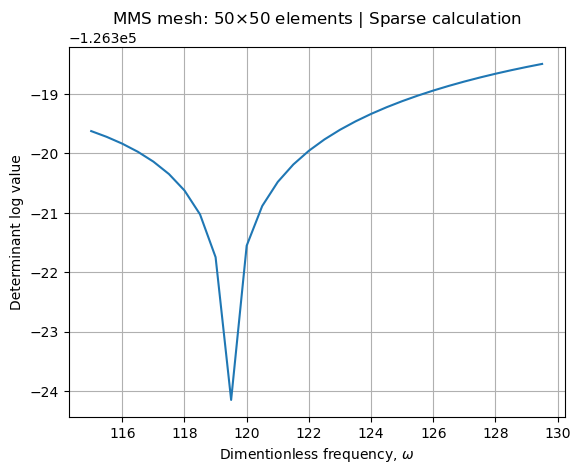


LEFT  : w = 119.0, log(|det(A)|) = -126321.74723520491
RIGHT : w = 120.0, log(|det(A)|) = -126321.55353098961


In [74]:
approximate_intervals, determinant_sign, determinant_log_value = find_approximate_intersection_intervals(
    omega_left_edge    = 115.0,
    omega_right_edge   = 130.0,
    omega_step         = 0.5
)

In [69]:
left_interval_edge = approximate_intervals[0][0]
right_interval_edge = approximate_intervals[0][1]

left_interval_edge = 222.0
right_interval_edge = 223.0

print(f"MMS mesh: {(Nx-1)}*{(Ny-1)} elements", end="\n\n")

if sparse_calculation == False:

    iterations, omega_precise = bisection_method(
        omega_left_edge  = left_interval_edge,
        omega_right_edge = right_interval_edge,
        precision        = 1e-6,
        max_iter         = 100,
    )

    print(f"Bisection method     | More precise omega: {round(omega_precise,6)} ({iterations} iterations)")

    iterations, omega_precise = chord_method(
        omega_left_edge  = left_interval_edge,
        omega_right_edge = right_interval_edge,
        precision        = 1e-6,
        max_iter         = 100,
    )

    print(f"Chord method         | More precise omega: {round(omega_precise,6)} ({iterations} iterations)")

result = scipy.optimize.minimize(
    sparse_determinant_function,
    x0            = left_interval_edge,
    method        = "Powell", # "Nelder-Mead", "L-BFGS-B", "Powell"
    bounds        = [(left_interval_edge, right_interval_edge)],
    tol           = 1e-6
)

print(f"Manual sparse search | More precise omega: {round(result.x[0],6)}")

if plate_info["shape"] in ["rectangular-beam-like", "rectangular-strip-beam-like"] or a > 50:
    print(f"\nManual sparse search | Nutural frequency lambda: {round(np.sqrt(result.x[0] * a**2 / np.sqrt(1 - v**2)),6)}")
if plate_info["shape"] in ["rectangular plate + beam"]:
    print(f"\nManual sparse search | Nutural frequency lambda: {round(result.x[0]/(2*np.pi),6)}")

MMS mesh: 10*10 elements

Bisection method     | More precise omega: 222.273026 (20 iterations)
Chord method         | More precise omega: 222.273027 (19 iterations)
Manual sparse search | More precise omega: 222.273027

Manual sparse search | Nutural frequency lambda: 35.375851
